In [3]:
# Setup cell - run this first
import subprocess
import sys

# List of required packages
required_packages = [
    'nltk',
    'pandas',
    'numpy',
    'matplotlib',
    'seaborn',
    'nest_asyncio',
    # Add other packages as needed
]

# Install missing packages
for package in required_packages:
    try:
        __import__(package)
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Download NLTK data
import nltk
nltk.download('punkt', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('stopwords', quiet=True)

print("✓ All packages installed and ready!")

Installing nltk...
  Using cached nltk-3.9.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached joblib-1.5.1-py3-none-any.whl.metadata (5.6 kB)
Using cached nltk-3.9.1-py3-none-any.whl (1.5 MB)
Using cached joblib-1.5.1-py3-none-any.whl (307 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [nltk]1/2 [nltk]
✓ All packages installed and ready!


In [1]:
# Import required libraries
import sys
import os
from pathlib import Path
import pandas as pd
import numpy as np
from datetime import datetime
import asyncio
import nest_asyncio

# Enable async in Jupyter
nest_asyncio.apply()

# Add project root to path
sys.path.append('..')

# Import our modules
from core.config import (
    ConfigManager,  # <-- This was missing
    RAGConfig, MetricsConfig, 
    LoaderConfig, ChunkerConfig, EmbeddingConfig,
    RetrievalConfig, GenerationConfig
)
from system.rag_system import ModularRAGSystem
from system.experiment_runner import ExperimentRunner
from analysis.results import ResultsAnalyzer
from utils import create_project_directories, verify_api_keys

# Setup directories
dirs = create_project_directories()
print("Project directories created")

# Verify API keys
api_status = verify_api_keys()
if not api_status.get("OPENAI_API_KEY"):
    print("Please set your OPENAI_API_KEY environment variable")
else:
    print("API keys verified")

Created documents directory: ./documents
Created data directory: ./data
Created configs directory: ./configs
Created results directory: ./results
Created logs directory: ./logs
Project directories created
OPENAI_API_KEY is configured
ANTHROPIC_API_KEY is not set
API keys verified


In [2]:
# Load your test questions from the spreadsheet
# Update this path to match your actual file location
questions_file = "./data/ab_testing_questions.xlsx"  # Update this path

# Read the Excel file
try:
    questions_df = pd.read_excel(questions_file)
    print(f"Loaded {len(questions_df)} questions from spreadsheet")
except FileNotFoundError:
    print(f"Could not find {questions_file}")
    print("Please update the path to your Excel file")
    # For demonstration, let's parse a few from your provided data
    questions_data = [
        {
            "Category": "Data Preparation",
            "Example Question": "What should I do if my file size exceeds the 4GB limit?",
            "Solution Type": "Diagnostic",
            "Follow Up Question": "How should I sample new data without biasing results?",
            "Follow Up Solution Type": "Procedural"
        },
        {
            "Category": "Data Preparation", 
            "Example Question": "What is the variant assignment column, and why is it important?",
            "Solution Type": "Clarifying",
            "Follow Up Question": "Some variant assignments are null; how does this impact my current experiment?",
            "Follow Up Solution Type": "Diagnostic"
        },
        {
            "Category": "Experimental Design",
            "Example Question": "What is Type I error (α), and how does it affect my experiment?",
            "Solution Type": "Clarifying",
            "Follow Up Question": "What effect does my chosen alpha (0.05) have on false positives here?",
            "Follow Up Solution Type": "Clarifying"
        },
        {
            "Category": "Assumption Checking",
            "Example Question": "If the QQ plot for an outcome metric deviates significantly from the diagonal line, what does this imply about the data distribution?",
            "Solution Type": "Diagnostic",
            "Follow Up Question": "What if Q-Q plots deviate from diagonal in my revenue data?",
            "Follow Up Solution Type": "Diagnostic"
        },
        {
            "Category": "CUPED Adjustment",
            "Example Question": "What is CUPED and how does it improve my experiment analysis?",
            "Solution Type": "Clarifying",
            "Follow Up Question": "How can I validate that CUPED adjustment improved sensitivity in my current dataset?",
            "Follow Up Solution Type": "Diagnostic"
        }
    ]
    questions_df = pd.DataFrame(questions_data)

# Display question statistics
print("\nQuestion Distribution:")
print(questions_df['Category'].value_counts())
print("\nSolution Type Distribution:")
print(questions_df['Solution Type'].value_counts())

# Prepare questions for testing
test_questions = []
for idx, row in questions_df.iterrows():
    # Main question
    test_questions.append({
        "id": f"q_{idx}_main",
        "question": row['Example Question'],
        "category": row['Category'].lower().replace(' ', '_'),
        "solution_type": row['Solution Type'].lower(),
        "is_follow_up": False
    })
    
    # Follow-up question if exists
    if pd.notna(row.get('Follow Up Question')):
        test_questions.append({
            "id": f"q_{idx}_followup",
            "question": row['Follow Up Question'],
            "category": row['Category'].lower().replace(' ', '_'),
            "solution_type": row.get('Follow Up Solution Type', 'clarifying').lower(),
            "is_follow_up": True
        })

print(f"\n✓ Prepared {len(test_questions)} test questions (including follow-ups)")

Could not find ./data/ab_testing_questions.xlsx
Please update the path to your Excel file

Question Distribution:
Category
Data Preparation       2
Experimental Design    1
Assumption Checking    1
CUPED Adjustment       1
Name: count, dtype: int64

Solution Type Distribution:
Solution Type
Clarifying    3
Diagnostic    2
Name: count, dtype: int64

✓ Prepared 10 test questions (including follow-ups)


In [3]:
# Path to your knowledge base PDF
# Update this to match your actual PDF location
knowledge_base_path = "./documents"  # Update if your PDF is elsewhere
pdf_file = "kb.pdf"  # Update with your actual PDF filename

# Check if PDF exists
pdf_path = Path(knowledge_base_path) / pdf_file
if not pdf_path.exists():
    print(f"PDF not found at {pdf_path}")
    print("Please update the path to your knowledge base PDF")
    print("\nLooking for PDFs in documents folder...")
    pdf_files = list(Path(knowledge_base_path).glob("*.pdf"))
    if pdf_files:
        print("Found PDFs:")
        for i, pdf in enumerate(pdf_files):
            print(f"  {i+1}. {pdf.name}")
        # Use the first PDF found
        pdf_path = pdf_files[0]
        print(f"\nUsing: {pdf_path}")
else:
    print(f"Found knowledge base PDF: {pdf_path}")

Found knowledge base PDF: documents/kb.pdf


2025-07-30 16:04:40,735 - system.rag_system - INFO - Initializing RAG system components


## Initializing RAG System Components

2025-07-30 16:04:40,737 - system.rag_system - INFO - Document processor initialized
✓ Document processor initialized
Initialized embeddings with model: text-embedding-3-small
2025-07-30 16:04:40,755 - system.rag_system - INFO - Vector store manager initialized
✓ Vector store manager initialized
2025-07-30 16:04:40,756 - system.rag_system - INFO - Component factories initialized
✓ Component factories initialized
2025-07-30 16:04:40,757 - system.rag_system - INFO - Pipeline builder initialized
✓ Pipeline builder initialized
2025-07-30 16:04:40,795 - system.rag_system - INFO - Evaluation systems initialized
✓ Evaluation systems initialized
RAG system initialized
2025-07-30 16:04:40,800 - document_processing.processor - INFO - Loading PDFs from directory: documents


Ignoring wrong pointing object 7 0 (offset 0)
Ignoring wrong pointing object 9 0 (offset 0)
Ignoring wrong pointing object 54 0 (offset 0)
Ignoring wrong pointing object 236 0 (offset 0)
Ignoring wrong pointing object 670 0 (offset 0)
Ignoring wrong pointing object 1329 0 (offset 0)
Ignoring wrong pointing object 1330 0 (offset 0)


2025-07-30 16:04:47,553 - document_processing.processor - INFO - Loaded 224 document pages


### Loading Summary

Loaded 224 document pages


#### First Document Preview:

Source: documents/kb.pdf
Page: 0
Content preview: RAG KNOWLEDGE BASE 
 
Explaining the Streamlit platform 
 
1. Experiment design tab: calculating sample sizes before running an 
experiment 
Purpose: Before launching an A/B test, we want to calculate...
2025-07-30 16:04:47,586 - document_processing.processor - INFO - Created 1645 chunks with recursive strategy


### Chunking Summary

Created 1645 chunks from 224 documents
Average chunk size: 341 characters


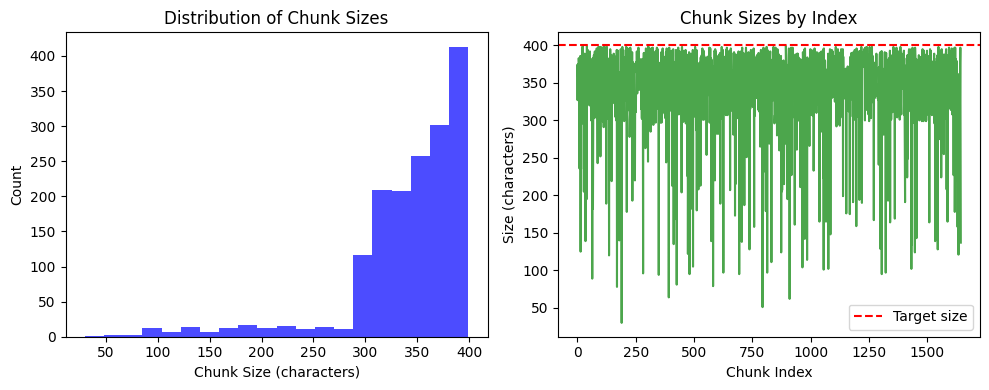


Chunk size statistics:
  Min: 30 chars
  Max: 399 chars
  Mean: 341 chars
  Target: 400 chars
Processed 1645 chunks from PDF

Sample chunks from your knowledge base:

Chunk 1:
Content: RAG KNOWLEDGE BASE 
 
Explaining the Streamlit platform 
 
1. Experiment design tab: calculating sample sizes before running an 
experiment 
Purpose: ...
Source: documents/kb.pdf
Page: 0

Chunk 2:
Content: can obtain the desired power of the experiment. 
Statistical Concept: We follow the "static test" design approach. 
In A/B testing, a static test mean...
Source: documents/kb.pdf
Page: 0

Chunk 3:
Content:  We run the experiment to completion based on that sample size. 
That’s why we need the sample size calculator: To figure out what number to predefin...
Source: documents/kb.pdf
Page: 0


## Vector Store Management

### Creating FAISS Vector Store

Processing 1645 chunks...
FAISS index saved to: ./data/faiss_index
Vector store created successfully

Vector store created


## Building RAG Pipeline

2025-07-30 16:04:56,286 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:04:56,323 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:04:56,324 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:04:56,324 - factories.retriever - INFO - Successfully created hybrid retriever
Created hybrid retriever
2025-07-30 16:04:56,325 - factories.generator - INFO - Created OpenAI generator with model gpt-4o-mini
2025-07-30 16:04:56,325 - factories.generator - INFO - Successfully created openai generator
Created openai generator
Built linear pipeline
Pipeline built - ready for testing!


In [5]:
# Create configuration optimized for A/B testing Q&A
base_config = RAGConfig(
    experiment_name="ab_testing_qa_evaluation",
    experiment_id=datetime.now().strftime("%Y%m%d_%H%M%S"),
    
    # Document processing - for PDF
    loader=LoaderConfig(type="pdf"),
    
    # Chunking strategy optimized for technical Q&A
    chunker=ChunkerConfig(
        method="recursive",
        chunk_size=400,  # Smaller chunks for precise answers
        chunk_overlap=100  # Good overlap for context
    ),
    
    # Embeddings
    embedding=EmbeddingConfig(
        provider="openai",
        model="text-embedding-3-small"
    ),
    
    # Retrieval - hybrid for best results
    retrieval=RetrievalConfig(
        strategy="hybrid",
        top_k=7  # More contexts for comprehensive answers
    ),
    
    # Generation
    generation=GenerationConfig(
        provider="openai",
        model="gpt-4o-mini",
        temperature=0.1,  # Low for consistency
        max_tokens=800
    ),
    
    # Comprehensive evaluation metrics
    metrics=MetricsConfig(
        metric_names=[
            # RAGAS metrics
            "ragas_faithfulness",
            "ragas_answer_relevancy",
            # CoFE-RAG metrics
            "cofe_retrieval_recall",
            "cofe_retrieval_accuracy", 
            "cofe_generation_faithfulness",
            "cofe_generation_relevance",
            "cofe_pipeline_score",
            # OmniEval metrics
            "omni_accuracy",
            "omni_completeness",
            "omni_hallucination",
            "omni_utilization",
            "omni_weighted_score",
            # General
            "response_time",
            "aggregate_score"
        ]
    )
)

# Initialize system
config_manager = ConfigManager(base_config)
rag_system = ModularRAGSystem(config_manager)
rag_system.initialize_components()
print("RAG system initialized")

# Load and process the PDF
chunks = rag_system.load_and_process_documents(str(pdf_path.parent))
print(f"Processed {len(chunks)} chunks from PDF")

# Show sample chunks to verify loading
print("\nSample chunks from your knowledge base:")
for i, chunk in enumerate(chunks[:3]):
    print(f"\nChunk {i+1}:")
    print(f"Content: {chunk.page_content[:150]}...")
    print(f"Source: {chunk.metadata.get('source', 'Unknown')}")
    print(f"Page: {chunk.metadata.get('page', 'N/A')}")

# Create vector store
vector_store = rag_system.create_or_load_vector_store(chunks, force_rebuild=True)
print("\nVector store created")

# Build pipeline
pipeline = rag_system.build_pipeline()
print("Pipeline built - ready for testing!")

In [6]:
# Test questions by category
categories = list(set(q['category'] for q in test_questions))

print("Testing Questions by Category:")
print("="*80)

category_results = {}

for category in categories[:5]:  # Test first 5 categories
    print(f"\n\nCATEGORY: {category.upper().replace('_', ' ')}")
    print("-"*60)
    
    # Get questions for this category
    cat_questions = [q for q in test_questions if q['category'] == category][:2]  # Max 2 per category
    
    category_scores = []
    
    for q in cat_questions:
        print(f"\nQuestion: {q['question']}")
        print(f"Type: {q['solution_type']} | Follow-up: {q['is_follow_up']}")
        
        # Run query
        result = await rag_system.query(
            question=q['question'],
            evaluate=True
        )
        
        print(f"\nAnswer:\n{result['answer'][:300]}...")  # Show first 300 chars
        
        # Store scores
        if 'evaluation' in result:
            eval_scores = result['evaluation']
            scores = {
                'faithfulness': eval_scores.get('ragas_faithfulness', 0),
                'relevancy': eval_scores.get('ragas_answer_relevancy', 0),
                'pipeline': eval_scores.get('cofe_pipeline_score', 0),
                'omni_score': eval_scores.get('omni_weighted_score', 0),
                'aggregate': eval_scores.get('aggregate_score', 0)
            }
            category_scores.append(scores)
            
            print(f"\nScores:")
            print(f"  Aggregate: {scores['aggregate']:.3f}")
            print(f"  Faithfulness: {scores['faithfulness']:.3f}")
            print(f"  Pipeline: {scores['pipeline']:.3f}")
    
    # Calculate category average
    if category_scores:
        avg_scores = {k: np.mean([s[k] for s in category_scores]) for k in category_scores[0].keys()}
        category_results[category] = avg_scores
        print(f"\nCategory Average Scores:")
        for metric, score in avg_scores.items():
            print(f"  {metric}: {score:.3f}")

Testing Questions by Category:


CATEGORY: DATA PREPARATION
------------------------------------------------------------

Question: What should I do if my file size exceeds the 4GB limit?
Type: diagnostic | Follow-up: False


### Query: What should I do if my file size exceeds the 4GB limit?

2025-07-30 16:06:16,790 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:06:16,831 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:06:16,832 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:06:16,832 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** The provided context does not contain any information regarding what to do if a file size exceeds the 4GB limit. Therefore, I cannot provide an answer to that question.


⏱️ Response time: 3.25s
📄 Retrieved 14 contexts
2025-07-30 16:06:30,546 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

### Query: How should I sample new data without biasing results?

2025-07-30 16:06:30,551 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:06:30,589 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:06:30,589 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:06:30,590 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** To sample new data without biasing results, you should follow these guidelines:

- **Random Sampling**: Ensure that test variations are distributed randomly among your audience. This prevents bias that could occur if specific groups are exposed to only one version. For example, avoid scenarios where "all men see version A and all women see version B," as this would make comparisons invalid.

- **Predefined Sample Size**: Establish a known baseline and reach a predefined sample size before analyzing the data. This helps maintain the reliability of the results and prevents premature conclusions.

- **Avoid Peeking**: Do not check the data before reaching the required sample size. Prematurely looking at results can lead to jumping to conclusions, which can degrade the reliability of the findings.

By adhering to these practices, you can minimize bias and enhance the accuracy of your results.


⏱️ Response time: 6.47s
📄 Retrieved 14 contexts
2025-07-30 16:06:57,296 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

### Query: What is Type I error (α), and how does it affect my experiment?

2025-07-30 16:06:57,304 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:06:57,350 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:06:57,350 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:06:57,350 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** Type I error (α) is defined as follows:

- **Definition**: Type I error, also known as a false positive, occurs when the null hypothesis is incorrectly rejected when it is actually true. This means concluding that there is an effect or difference when there isn't one.

- **Significance Level**: The probability of committing a Type I error is referred to as the significance level (α). A common value for α is 0.05, which implies a 5% chance of incorrectly rejecting the true null hypothesis.

- **Impact on Experiments**:
  - If α is set at 0.05, it indicates that there is an acceptable risk of 5% for concluding that an effect exists when it does not.
  - A lower α reduces the likelihood of a Type I error but may increase the probability of a Type II error (failing to detect a real effect).

In summary, Type I error affects experiments by determining the threshold for claiming a statistically significant result, influencing the reliability of the conclusions drawn from the data.


⏱️ Response time: 5.10s
📄 Retrieved 13 contexts
2025-07-30 16:07:29,312 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

### Query: What effect does my chosen alpha (0.05) have on false positives here?

2025-07-30 16:07:29,319 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:07:29,361 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:07:29,362 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:07:29,362 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** Choosing an alpha level of 0.05 has the following effect on false positives:

- **Type I Error (False Positive)**: Setting alpha (α) at 0.05 means there is a 5% chance of committing a Type I error, which is the probability of rejecting the null hypothesis when it is actually true. This indicates that there is a 5% chance of concluding that there is an effect when there isn't one.

- **Common Acceptance**: The level of 0.05 is a commonly accepted standard for balancing the risk of false positives and false negatives in hypothesis testing. 

In summary, an alpha of 0.05 allows for a 5% probability of false positives in the results of the hypothesis test.


⏱️ Response time: 3.40s
📄 Retrieved 14 contexts
2025-07-30 16:07:56,338 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

### Query: What is CUPED and how does it improve my experiment analysis?

2025-07-30 16:07:56,347 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:07:56,416 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:07:56,416 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:07:56,417 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** CUPED stands for Controlled-experiment Using Pre-Experiment Data. It is a statistical technique that enhances the analysis of experiments by incorporating historical data as a covariate. Here’s how CUPED improves experiment analysis:

- **Variance Reduction**: CUPED provides a robust mechanism for reducing variance in experimental data, which leads to tighter confidence intervals. This allows analysts to make more confident decisions based on their data.
  
- **Utilization of Historical Data**: By leveraging pre-experiment data, CUPED not only analyzes current experiment data but also incorporates historical information, resulting in a richer contextual understanding of the results.

- **Improved Accuracy**: CUPED helps in reducing noise that can obscure the clarity of experimental findings, enabling more accurate interpretations and conclusions.

- **Faster and Less Biased Experiments**: The method is designed to run experiments more quickly and with reduced bias, enhancing the overall efficiency of data-driven decision-making processes.

In summary, CUPED is a powerful tool for increasing the speed and accuracy of experimentation programs, making it essential for data analysts in software development and data-heavy industries.


⏱️ Response time: 5.63s
📄 Retrieved 12 contexts
2025-07-30 16:08:24,283 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

### Query: How can I validate that CUPED adjustment improved sensitivity in my current dataset?

2025-07-30 16:08:24,293 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:08:24,336 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:08:24,336 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:08:24,337 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** To validate that CUPED adjustment improved sensitivity in your current dataset, you can follow these steps based on the provided context:

- **Compare Variance Reduction**: Assess the reduction in variance after applying CUPED. The context states that "When we apply CUPED, we see a large reduction in variance and p-value," indicating that a successful implementation should show lower variance in your outcome metrics.

- **Evaluate Statistical Significance**: Check for an increase in the statistical significance of your results. CUPED is designed to enhance the power of your tests, which means you should observe a higher chance of finding statistically significant results when they truly exist.

- **Analyze Effect Size**: Look for improvements in detecting small effects. The context mentions that CUPED improves sensitivity, making it better at detecting these effects.

- **Use Pre-Experiment Data**: Ensure that you are using relevant historical metrics as covariates that correlate with your experimental outcomes, as this is crucial for CUPED's effectiveness.

- **Conduct Standard Analysis**: After applying CUPED, apply standard techniques to analyze the experimental results. This will allow you to benefit from the statistical improvements without altering your fundamental A/B testing methodology.

By following these steps, you can validate the effectiveness of CUPED in improving sensitivity in your dataset.


⏱️ Response time: 10.99s
📄 Retrieved 14 contexts
2025-07-30 16:08:58,620 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_da

### Query: If the QQ plot for an outcome metric deviates significantly from the diagonal line, what does this imply about the data distribution?

2025-07-30 16:08:58,632 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:08:58,680 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:08:58,680 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:08:58,681 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** If the Q-Q plot for an outcome metric deviates significantly from the diagonal line (the identity line), it implies that the data is likely not normally distributed. Specifically, the context states:

- "If the points curve away from the line (especially at the tails) then the data is likely not normally distributed." (Document 1, Source: kb.pdf, Page: 6, Chunk: 6) 

This indicates that significant deviation from the diagonal line suggests a departure from normality in the data distribution.


⏱️ Response time: 2.67s
📄 Retrieved 12 contexts
2025-07-30 16:09:12,119 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

### Query: What if Q-Q plots deviate from diagonal in my revenue data?

2025-07-30 16:09:12,126 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:09:12,181 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:09:12,182 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:09:12,183 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** If Q-Q plots deviate from the diagonal (the 45° line), it suggests that the distribution of your revenue data is not normal. Specifically:

- If the points curve away from the line, especially at the tails, it indicates that the data is likely not normally distributed.
- This deviation can imply that one of the distributions being compared is more skewed than the other or has heavier tails.

In summary, a deviation from the diagonal in a Q-Q plot indicates potential issues with normality in your revenue data.


⏱️ Response time: 3.02s
📄 Retrieved 14 contexts
2025-07-30 16:09:26,619 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

In [7]:
# Analyze performance by solution type
print("\n\nTesting by Solution Type:")
print("="*80)

solution_types = list(set(q['solution_type'] for q in test_questions))
solution_results = {}

for sol_type in solution_types:
    print(f"\n\nSOLUTION TYPE: {sol_type.upper()}")
    print("-"*60)
    
    # Get sample questions
    type_questions = [q for q in test_questions if q['solution_type'] == sol_type][:3]
    
    type_scores = []
    
    for q in type_questions:
        print(f"\nQ: {q['question'][:100]}...")
        
        result = await rag_system.query(q['question'], evaluate=True)
        
        if 'evaluation' in result:
            scores = {
                'aggregate': result['evaluation'].get('aggregate_score', 0),
                'accuracy': result['evaluation'].get('omni_accuracy', 0),
                'completeness': result['evaluation'].get('omni_completeness', 0),
                'response_time': result['response_time']
            }
            type_scores.append(scores)
            print(f"  Score: {scores['aggregate']:.3f} | Time: {scores['response_time']:.2f}s")
    
    # Average for this type
    if type_scores:
        avg_scores = {k: np.mean([s[k] for s in type_scores]) for k in type_scores[0].keys()}
        solution_results[sol_type] = avg_scores
        print(f"\nAverage for {sol_type}:")
        print(f"  Score: {avg_scores['aggregate']:.3f}")
        print(f"  Response Time: {avg_scores['response_time']:.2f}s")



Testing by Solution Type:


SOLUTION TYPE: CLARIFYING
------------------------------------------------------------

Q: What is the variant assignment column, and why is it important?...


### Query: What is the variant assignment column, and why is it important?

2025-07-30 16:09:50,659 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:09:50,698 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:09:50,698 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:09:50,699 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** The variant assignment column refers to the categorization of users into different variants during an A/B test. In this context, variants are different versions of a product, feature, or experience being compared. Specifically:

- **Variant 0** typically represents the control group (the default version).
- **Variant 1 and Variant 2** represent treatment groups (alternative versions).

The importance of the variant assignment column lies in its role in ensuring that:

- **Randomization**: Users are assigned to variants in a way that is independent of their segments, which is crucial for the validity of the test.
- **Balanced Mix**: Each variant should include a balanced mix of users from all segments, as indicated by the null hypothesis (Ho) stating that "variant assignment is independent of the segment."
- **Data Reliability**: It helps in validating that the data collected is reliable and correctly structured, allowing for trustworthy conclusions to be drawn from the experiment.

Overall, the variant assignment column is essential for assessing the effectiveness of different versions and ensuring the integrity of the A/B testing process.


⏱️ Response time: 4.73s
📄 Retrieved 12 contexts
2025-07-30 16:10:20,006 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

### Query: What is Type I error (α), and how does it affect my experiment?

2025-07-30 16:10:20,017 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:10:20,063 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:10:20,063 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:10:20,064 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** Type I error (α), also known as a false positive, occurs when a statistical test incorrectly rejects a true null hypothesis. This means that the test concludes there is an effect or difference when, in reality, there is none. 

Key points about Type I error (α):

- **Definition**: It is the probability of rejecting the null hypothesis when it is true.
- **Significance Level**: The significance level (α) is commonly set at 0.05, indicating a 5% chance of making a Type I error.
- **Impact on Experiments**: 
  - A Type I error can lead to false conclusions about the effectiveness of an intervention or treatment, suggesting that it works when it does not.
  - It can result in unnecessary changes or implementations based on incorrect findings.

In summary, Type I error affects experiments by potentially leading to incorrect decisions based on false positives, which can have significant implications for research outcomes and practical applications.


⏱️ Response time: 5.06s
📄 Retrieved 13 contexts
2025-07-30 16:10:46,639 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

### Query: What effect does my chosen alpha (0.05) have on false positives here?

2025-07-30 16:10:46,652 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:10:46,723 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:10:46,724 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:10:46,724 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** Choosing an alpha level of 0.05 has the following effect on false positives:

- **Type I Error (False Positive)**: Setting alpha (α) at 0.05 means there is a 5% chance of committing a Type I error, which occurs when the test incorrectly rejects the null hypothesis when it is true. This indicates that there is a 5% probability of concluding that there is an effect when there actually isn't one.

- **Common Acceptance**: The alpha level of 0.05 is a commonly accepted standard in hypothesis testing, balancing the risk of false positives and false negatives.

In summary, an alpha of 0.05 allows for a 5% chance of false positives in the results of the hypothesis test.


⏱️ Response time: 5.10s
📄 Retrieved 14 contexts
2025-07-30 16:11:06,909 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

### Query: What should I do if my file size exceeds the 4GB limit?

2025-07-30 16:11:06,915 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:11:06,959 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:11:06,959 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:11:06,959 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** The provided context does not contain any information regarding what to do if a file size exceeds the 4GB limit. Therefore, I cannot provide an answer based on the available information.


⏱️ Response time: 1.77s
📄 Retrieved 14 contexts
2025-07-30 16:11:15,512 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

### Query: Some variant assignments are null; how does this impact my current experiment?

2025-07-30 16:11:15,519 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:11:15,564 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:11:15,565 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:11:15,565 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** The context provided does not contain specific information regarding the impact of null variant assignments on an experiment. Therefore, I cannot provide a clear answer to how null variant assignments would affect your current experiment.


⏱️ Response time: 1.98s
📄 Retrieved 14 contexts
2025-07-30 16:11:24,827 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

### Query: If the QQ plot for an outcome metric deviates significantly from the diagonal line, what does this imply about the data distribution?

2025-07-30 16:11:24,831 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:11:24,868 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:11:24,868 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:11:24,868 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** If the Q-Q plot for an outcome metric deviates significantly from the diagonal line (the identity line), it implies that the data is likely not normally distributed. Specifically, the context states:

- "If the points curve away from the line (especially at the tails) then the data is likely not normally distributed." (Document 1, Source: kb.pdf, Page: 6, Chunk: 6) 

This indicates that significant deviation from the diagonal line suggests a departure from normality in the data distribution.


⏱️ Response time: 3.12s
📄 Retrieved 12 contexts
2025-07-30 16:11:36,775 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

### Query: How should I sample new data without biasing results?

2025-07-30 16:11:36,782 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:11:36,839 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:11:36,840 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:11:36,840 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** To sample new data without biasing results, you should follow these guidelines:

- **Random Sampling**: Ensure that test variations are distributed randomly among your audience. This prevents bias that could occur if specific groups are exposed to only one version. For example, "If all men see version A and all women see version B, you can't compare" the results accurately.

- **Predefined Sample Size**: Determine the sample size in advance and do not check the data until the required sample size per variation is reached. This avoids premature conclusions that can degrade the reliability of the results. As stated, "it requires a known baseline and reaching a predefined sample size before we’re allowed to look at the data and draw conclusions."

- **Avoid Peeking**: Resist the urge to look at the data before the sample size is met, as this can lead to inflated expectations and incorrect conclusions. Peeking is likened to "baking a cake, opening the oven and deciding the cake is ready before it’s fully finished."

By adhering to these practices, you can minimize bias and improve the reliability of your results.


⏱️ Response time: 5.07s
📄 Retrieved 14 contexts
2025-07-30 16:12:02,947 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Running A/B test with:
  - 8 test questions
  - Testing variants: {'chunker.method': ['recursive', 'semantic'], 'chunker.chunk_size': [400, 600], 'retrieval.strategy': ['vector', 'hybrid'], 'retrieval.top_k': [5, 7]}
Running A/B test with 16 configurations

Configuration 1/16
Variant: {'loader': 'pdf', 'chunker': 'semantic_600', 'embedding': 'openai_text-embedding-3-small', 'storage': 'faiss', 'retrieval': 'hybrid_k7', 'generation': 'openai_gpt-4o-mini'}
2025-07-30 16:14:40,457 - system.rag_system - INFO - Initializing RAG system components


## Initializing RAG System Components

2025-07-30 16:14:40,458 - system.rag_system - INFO - Document processor initialized
✓ Document processor initialized
Initialized embeddings with model: text-embedding-3-small
2025-07-30 16:14:40,488 - system.rag_system - INFO - Vector store manager initialized
✓ Vector store manager initialized
2025-07-30 16:14:40,489 - system.rag_system - INFO - Component factories initialized
✓ Component factories initialized
2025-07-30 16:14:40,490 - system.rag_system - INFO - Pipeline builder initialized
✓ Pipeline builder initialized
2025-07-30 16:14:40,510 - system.rag_system - INFO - Evaluation systems initialized
✓ Evaluation systems initialized
2025-07-30 16:14:40,511 - document_processing.processor - INFO - Loading PDFs from directory: documents


Ignoring wrong pointing object 7 0 (offset 0)
Ignoring wrong pointing object 9 0 (offset 0)
Ignoring wrong pointing object 54 0 (offset 0)
Ignoring wrong pointing object 236 0 (offset 0)
Ignoring wrong pointing object 670 0 (offset 0)
Ignoring wrong pointing object 1329 0 (offset 0)
Ignoring wrong pointing object 1330 0 (offset 0)


2025-07-30 16:14:47,482 - document_processing.processor - INFO - Loaded 224 document pages


### Loading Summary

Loaded 224 document pages


#### First Document Preview:

Source: documents/kb.pdf
Page: 0
Content preview: RAG KNOWLEDGE BASE 
 
Explaining the Streamlit platform 
 
1. Experiment design tab: calculating sample sizes before running an 
experiment 
Purpose: Before launching an A/B test, we want to calculate...
2025-07-30 16:14:47,484 - document_processing.processor - WARNING - Semantic chunking not yet implemented, falling back to recursive
2025-07-30 16:14:47,507 - document_processing.processor - INFO - Created 1027 chunks with recursive strategy


### Chunking Summary

Created 1027 chunks from 224 documents
Average chunk size: 512 characters


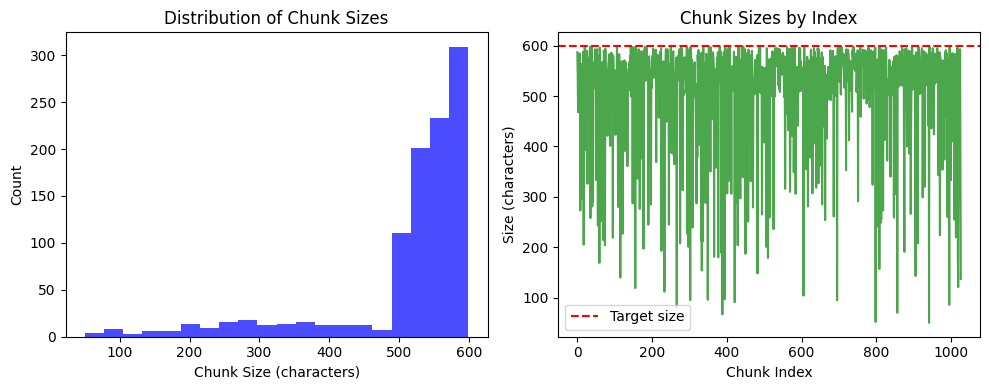


Chunk size statistics:
  Min: 50 chars
  Max: 599 chars
  Mean: 512 chars
  Target: 600 chars


## Vector Store Management

### Creating FAISS Vector Store

Processing 1027 chunks...
FAISS index saved to: ./data/faiss_index
Vector store created successfully


## Building RAG Pipeline

2025-07-30 16:14:51,712 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:14:51,745 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:14:51,746 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:14:51,746 - factories.retriever - INFO - Successfully created hybrid retriever
Created hybrid retriever
2025-07-30 16:14:51,747 - factories.generator - INFO - Created OpenAI generator with model gpt-4o-mini
2025-07-30 16:14:51,747 - factories.generator - INFO - Successfully created openai generator
Created openai generator
Built linear pipeline


Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

### Query: What should I do if my file size exceeds the 4GB limit?

2025-07-30 16:14:51,768 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:14:51,808 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:14:51,809 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:14:51,809 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** The provided context does not contain any information regarding what to do if a file size exceeds the 4GB limit. Therefore, I cannot provide an answer to that question based on the available information.


⏱️ Response time: 1.87s
📄 Retrieved 14 contexts
2025-07-30 16:14:59,659 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  12%|█▎        | 1/8 [00:07<00:55,  7.90s/it]

### Query: How should I sample new data without biasing results?

2025-07-30 16:14:59,670 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:14:59,768 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:14:59,769 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:14:59,770 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** To sample new data without biasing results, consider the following guidelines based on the provided context:

- **Use of Covariates**: Since new users won’t have pre-experiment data, leverage covariates like demographics if possible. This helps in analyzing the data without introducing bias.
  
- **CUPED Method**: If the experiment includes both new and established users, apply the CUPED method only to users with pre-experiment data. This allows for a more accurate analysis by controlling for variance related to historical behavior.

- **Blind Analyses**: Conduct blind analyses where the group assignments (control or test) are unknown during data analysis. This helps maintain objectivity and reduces bias in interpreting results.

- **Maintain Skepticism**: Approach test results critically, especially if outcomes are unexpectedly positive. This mindset helps avoid human bias and ensures a more objective analysis.

These practices can help ensure that the sampling of new data does not introduce bias into the results.


⏱️ Response time: 4.99s
📄 Retrieved 13 contexts
2025-07-30 16:15:33,341 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  25%|██▌       | 2/8 [00:41<02:18, 23.07s/it]

### Query: What is Type I error (α), and how does it affect my experiment?

2025-07-30 16:15:33,351 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:15:33,390 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:15:33,390 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:15:33,391 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** Type I error (α), also known as a false positive, occurs when a null hypothesis is incorrectly rejected when it is actually true. This means that the test concludes there is an effect or difference when there is none. 

Key points about Type I error (α) and its effects on experiments:

- **Definition**: Type I error is the erroneous rejection of a true null hypothesis. It is sometimes referred to as an error of commission.
- **Significance Level**: The significance level (α) is the probability of committing a Type I error. A common value for α is set at 0.05, indicating a 5% risk of incorrectly rejecting the null hypothesis.
- **Impact on Experiments**:
  - If a Type I error occurs, it can lead to false conclusions about the effectiveness of a treatment or intervention, potentially resulting in misguided decisions based on incorrect data.
  - The lower the significance level (α), the lower the probability of a Type I error, but this may increase the probability of a Type II error (false negative).

In summary, Type I error can significantly affect the validity of experimental results by leading to incorrect conclusions about the presence of an effect or difference.


⏱️ Response time: 5.52s
📄 Retrieved 12 contexts
2025-07-30 16:16:05,706 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  38%|███▊      | 3/8 [01:13<02:16, 27.31s/it]

### Query: What effect does my chosen alpha (0.05) have on false positives here?

2025-07-30 16:16:05,711 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:16:05,745 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:16:05,745 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:16:05,745 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** Choosing an alpha level of 0.05 has the following effects on false positives:

- **Probability of False Positives**: An alpha level of 0.05 means there is a 5% chance of committing a type I error, which is a false positive. This indicates that there is a 95% chance that the null hypothesis is correct and that the treatment is no better than the control.
- **Balance with Type II Error**: Lowering the alpha level would decrease the probability of false positives but would increase the probability of type II errors (false negatives). The context states, "The closer to 0, the lower the probability of a type I error/false positive, but the higher the probability of a type II error/false negative."
- **Common Acceptance**: The alpha level of 0.05 is commonly accepted as a "happy middle ground" for balancing the risks of false positives and false negatives.

In summary, an alpha of 0.05 allows for a controlled risk of false positives while maintaining a reasonable chance of detecting true effects.


⏱️ Response time: 4.85s
📄 Retrieved 12 contexts
2025-07-30 16:16:33,881 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  50%|█████     | 4/8 [01:42<01:50, 27.65s/it]

### Query: What is CUPED and how does it improve my experiment analysis?

2025-07-30 16:16:33,888 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:16:33,923 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:16:33,924 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:16:33,924 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** CUPED, which stands for Controlled-experiment Using Pre-Experiment Data, is a statistical modeling technique that enhances the speed and accuracy of experimentation programs. It was introduced by Microsoft in 2013 and is increasingly used in online experimentation.

### How CUPED Improves Experiment Analysis:

- **Variance Reduction**: CUPED incorporates pre-experiment metrics to adjust and refine estimates from ongoing experiments, thereby reducing noise (unwanted variability) in the data. This leads to:
  - Enhanced statistical power and precision of experimental results.
  - Improved ability to detect true treatment effects that may be obscured by randomness.

- **Contextual Understanding**: By analyzing both current and historical data, CUPED provides a richer contextual understanding of user behavior, which aids in making more informed decisions.

- **Sample Size Efficiency**: CUPED can significantly reduce the sample sizes needed for experiments, allowing for quicker turnarounds and enabling teams to iterate rapidly. This is particularly beneficial in fast-paced environments.

- **Robust Mechanism for Decision-Making**: It empowers analysts by providing a structured approach to improving statistical estimates, leading to more reliable conclusions from experimental data.

- **Adjustment of Metrics**: The CUPED algorithm adjusts treated and control group metrics based on pre-experiment data, often using linear regression to model relationships between outcome variables and covariates.

In summary, CUPED is a powerful tool for improving the reliability and efficiency of experiment analysis by leveraging historical data to reduce variance and enhance the clarity of findings.


⏱️ Response time: 6.32s
📄 Retrieved 12 contexts
2025-07-30 16:17:18,565 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  62%|██████▎   | 5/8 [02:26<01:41, 33.80s/it]

### Query: How can I validate that CUPED adjustment improved sensitivity in my current dataset?

2025-07-30 16:17:18,579 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:17:18,618 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:17:18,619 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:17:18,619 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** To validate that CUPED adjustment improved sensitivity in your current dataset, you can follow these steps based on the context provided:

- **Compare Results Before and After CUPED**: Analyze the experimental results both with and without CUPED adjustments. Look for differences in the statistical power and precision of the estimates.
  
- **Examine Confidence Intervals**: Check if the confidence intervals have tightened after applying CUPED. The context states, "This tightening of confidence intervals is what makes CUPED so effective."

- **Assess Variance Reduction**: Evaluate the variance in your outcome metric before and after applying CUPED. The technique is designed to "reduce variance in your outcome metric by using pre-experiment information that’s correlated with the outcome."

- **Look for Detection of True Effects**: Determine if CUPED has enabled the detection of true treatment effects that were previously obscured by randomness, as mentioned, "the adjustments made by CUPED often lead to detecting true treatment effects that may otherwise be obscured by randomness."

- **Utilize Statistical Tests**: Conduct statistical tests to compare the sensitivity of the results. Ensure that the assumptions of normality hold, as CUPED operates effectively under this assumption.

By following these steps, you can validate the effectiveness of CUPED adjustments in improving sensitivity in your dataset.


⏱️ Response time: 5.84s
📄 Retrieved 13 contexts
2025-07-30 16:17:52,635 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  75%|███████▌  | 6/8 [03:00<01:07, 33.89s/it]

### Query: If the QQ plot for an outcome metric deviates significantly from the diagonal line, what does this imply about the data distribution?

2025-07-30 16:17:52,642 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:17:52,678 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:17:52,679 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:17:52,679 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** If the Q-Q plot for an outcome metric deviates significantly from the diagonal line (identity line y = x), it implies that the data distribution is not normal. Specifically:

- Points that curve away from the line suggest that the data is likely not normally distributed.
- If the points are above or below the line, it indicates that the distributions differ.

This is important because, as noted, "if the data is not normal, the test might give misleading results."


⏱️ Response time: 3.01s
📄 Retrieved 12 contexts
2025-07-30 16:18:08,592 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  88%|████████▊ | 7/8 [03:16<00:28, 28.03s/it]

### Query: What if Q-Q plots deviate from diagonal in my revenue data?

2025-07-30 16:18:08,604 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:18:08,644 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:18:08,645 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:18:08,645 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** If Q–Q plots deviate from the diagonal line (y = x) in your revenue data, it indicates that the distributions being compared are not similar. Specifically:

- If the points in the Q–Q plot lie below the line y = x, it suggests that the distribution plotted on the horizontal axis is more dispersed than the distribution on the vertical axis.
- Conversely, if the points lie above the line y = x, it indicates that the distribution on the vertical axis is more dispersed than the one on the horizontal axis.
- Additionally, if the plot is arced or S-shaped, this may suggest that one of the distributions is more skewed or has heavier tails than the other.

These deviations can provide insights into the differences in properties such as location, scale, and skewness between the two distributions being compared.


⏱️ Response time: 5.86s
📄 Retrieved 13 contexts
2025-07-30 16:18:29,203 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating: 100%|██████████| 8/8 [03:37<00:00, 27.18s/it]


Configuration 2/16
Variant: {'loader': 'pdf', 'chunker': 'semantic_600', 'embedding': 'openai_text-embedding-3-small', 'storage': 'faiss', 'retrieval': 'hybrid_k7', 'generation': 'openai_gpt-4o-mini'}
2025-07-30 16:18:29,208 - system.rag_system - INFO - Initializing RAG system components


## Initializing RAG System Components

2025-07-30 16:18:29,210 - system.rag_system - INFO - Document processor initialized
✓ Document processor initialized
Initialized embeddings with model: text-embedding-3-small
2025-07-30 16:18:29,227 - system.rag_system - INFO - Vector store manager initialized
✓ Vector store manager initialized
2025-07-30 16:18:29,228 - system.rag_system - INFO - Component factories initialized
✓ Component factories initialized
2025-07-30 16:18:29,228 - system.rag_system - INFO - Pipeline builder initialized
✓ Pipeline builder initialized
2025-07-30 16:18:29,268 - system.rag_system - INFO - Evaluation systems initialized
✓ Evaluation systems initialized
2025-07-30 16:18:29,269 - document_processing.processor - INFO - Loading PDFs from directory: documents


Ignoring wrong pointing object 7 0 (offset 0)
Ignoring wrong pointing object 9 0 (offset 0)
Ignoring wrong pointing object 54 0 (offset 0)
Ignoring wrong pointing object 236 0 (offset 0)
Ignoring wrong pointing object 670 0 (offset 0)
Ignoring wrong pointing object 1329 0 (offset 0)
Ignoring wrong pointing object 1330 0 (offset 0)


2025-07-30 16:18:36,077 - document_processing.processor - INFO - Loaded 224 document pages


### Loading Summary

Loaded 224 document pages


#### First Document Preview:

Source: documents/kb.pdf
Page: 0
Content preview: RAG KNOWLEDGE BASE 
 
Explaining the Streamlit platform 
 
1. Experiment design tab: calculating sample sizes before running an 
experiment 
Purpose: Before launching an A/B test, we want to calculate...
2025-07-30 16:18:36,079 - document_processing.processor - WARNING - Semantic chunking not yet implemented, falling back to recursive
2025-07-30 16:18:36,106 - document_processing.processor - INFO - Created 1027 chunks with recursive strategy


### Chunking Summary

Created 1027 chunks from 224 documents
Average chunk size: 512 characters


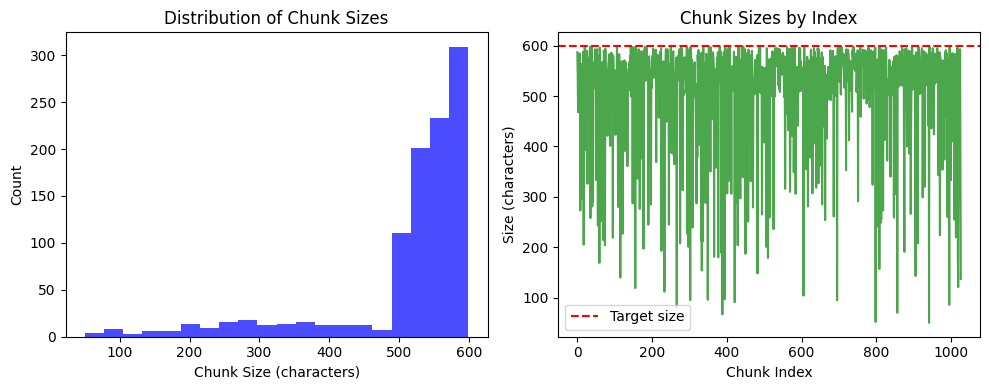


Chunk size statistics:
  Min: 50 chars
  Max: 599 chars
  Mean: 512 chars
  Target: 600 chars


## Vector Store Management

### Creating FAISS Vector Store

Processing 1027 chunks...
FAISS index saved to: ./data/faiss_index
Vector store created successfully


## Building RAG Pipeline

2025-07-30 16:18:40,328 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:18:40,362 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:18:40,362 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:18:40,363 - factories.retriever - INFO - Successfully created hybrid retriever
Created hybrid retriever
2025-07-30 16:18:40,363 - factories.generator - INFO - Created OpenAI generator with model gpt-4o-mini
2025-07-30 16:18:40,364 - factories.generator - INFO - Successfully created openai generator
Created openai generator
Built linear pipeline


Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

### Query: What should I do if my file size exceeds the 4GB limit?

2025-07-30 16:18:40,366 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:18:40,401 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:18:40,401 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:18:40,401 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** The provided context does not contain any information regarding what to do if a file size exceeds the 4GB limit. Therefore, I cannot provide an answer to that question based on the available information.


⏱️ Response time: 2.86s
📄 Retrieved 14 contexts
2025-07-30 16:18:49,667 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  12%|█▎        | 1/8 [00:09<01:05,  9.31s/it]

### Query: How should I sample new data without biasing results?

2025-07-30 16:18:49,675 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:18:49,716 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:18:49,717 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:18:49,717 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** To sample new data without biasing results, consider the following guidelines based on the provided context:

- **Use of Covariates**: Since new users lack pre-experiment data, leverage covariates like demographics when possible. This helps in controlling for potential biases.
  
- **CUPED Methodology**: If your experiment includes both new and established users, apply the CUPED (Controlled, Unbiased, Pre-Experiment Data) method only to users with pre-experiment data. This allows for more reliable results by reducing variance.

- **Blind Analyses**: Conduct analyses without knowing which group is the control or treatment. This helps maintain objectivity and reduces bias in interpreting results.

- **Maintain Skepticism**: Approach test results critically, especially if outcomes are unexpectedly positive. This mindset helps avoid human bias and ensures a more objective analysis.

These practices can help ensure that the sampling of new data does not introduce bias into the results.


⏱️ Response time: 5.45s
📄 Retrieved 13 contexts
2025-07-30 16:19:14,043 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  25%|██▌       | 2/8 [00:33<01:49, 18.17s/it]

### Query: What is Type I error (α), and how does it affect my experiment?

2025-07-30 16:19:14,049 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:19:14,086 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:19:14,086 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:19:14,086 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** Type I error (α), also known as a false positive, occurs when a null hypothesis is incorrectly rejected when it is actually true. This means that the test suggests there is an effect or difference when there is none. 

Key points regarding Type I error (α) and its impact on experiments:

- **Definition**: Type I error is the erroneous rejection of a true null hypothesis. It can be thought of as an error of commission, where the status quo is mistakenly rejected in favor of misleading information.
- **Significance Level**: The significance level (α) is the probability of committing a Type I error. A common value for α is set at 0.05, indicating a 5% chance of incorrectly rejecting the null hypothesis.
- **Impact on Experiments**:
  - If α is set too high, the likelihood of making a Type I error increases, leading to false conclusions about the effectiveness of a treatment or intervention.
  - Balancing α is crucial; lowering α reduces the chance of Type I errors but may increase the chance of Type II errors (failing to reject a false null hypothesis).

In summary, Type I error affects experiments by potentially leading to incorrect conclusions about the presence of an effect, which can misguide further research or practical applications.


⏱️ Response time: 8.24s
📄 Retrieved 12 contexts
2025-07-30 16:19:49,138 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  38%|███▊      | 3/8 [01:08<02:09, 25.90s/it]

### Query: What effect does my chosen alpha (0.05) have on false positives here?

2025-07-30 16:19:49,147 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:19:49,183 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:19:49,184 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:19:49,184 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** Choosing an alpha level of 0.05 has the following effects on false positives:

- **Probability of False Positives**: An alpha level of 0.05 means there is a 5% chance of committing a Type I error, which is a false positive. This indicates that there is a 95% chance that the null hypothesis is correct and that the treatment is no better than the control.
- **Balance with Type II Errors**: Lowering the alpha level can reduce the probability of false positives but may increase the probability of Type II errors (false negatives). The context states, "The closer to 0, the lower the probability of a type I error/false positive, but the higher the probability of a type II error/false negative."

In summary, setting alpha at 0.05 allows for a controlled risk of false positives while balancing the risk of false negatives.


⏱️ Response time: 9.00s
📄 Retrieved 12 contexts
2025-07-30 16:20:20,171 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  50%|█████     | 4/8 [01:39<01:51, 27.93s/it]

### Query: What is CUPED and how does it improve my experiment analysis?

2025-07-30 16:20:20,178 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:20:20,213 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:20:20,213 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:20:20,213 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** CUPED, which stands for Controlled-experiment Using Pre-Experiment Data, is a statistical modeling technique that enhances the speed and accuracy of experimentation programs. Here’s how it improves experiment analysis:

- **Variance Reduction**: CUPED incorporates pre-experiment metrics to adjust and refine estimates from ongoing experiments, which helps mitigate noise (unwanted variability) in the data. This leads to:
  - Enhanced statistical power and precision of experimental results.
  - Improved ability to detect true treatment effects that might be obscured by randomness.

- **Contextual Understanding**: By analyzing both current and historical data, CUPED provides a richer contextual understanding of user behavior, allowing for more accurate interpretations and decisions based on the data.

- **Efficiency in Experimentation**: CUPED can significantly reduce the sample sizes needed for experiments, leading to quicker turnarounds. This is particularly beneficial in fast-paced environments where rapid iteration is crucial.

- **Robust Mechanism for Decision-Making**: It empowers analysts to draw reliable conclusions from experiments, thereby improving the overall efficiency of data-driven decision-making processes.

In summary, CUPED is a powerful tool for improving the reliability and efficiency of experiment analysis by leveraging historical data to reduce variance and enhance the clarity of findings.


⏱️ Response time: 5.77s
📄 Retrieved 12 contexts
2025-07-30 16:20:56,301 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  62%|██████▎   | 5/8 [02:15<01:32, 30.89s/it]

### Query: How can I validate that CUPED adjustment improved sensitivity in my current dataset?

2025-07-30 16:20:56,312 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:20:56,350 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:20:56,350 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:20:56,351 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** To validate that CUPED adjustment improved sensitivity in your current dataset, you can follow these steps based on the context provided:

- **Compare Pre- and Post-CUPED Results**: Analyze the outcomes of your experiments before and after applying CUPED. Look for improvements in the statistical power and precision of the results.
  
- **Examine Confidence Intervals**: Check if the confidence intervals have tightened after applying CUPED. The context states, "This tightening of confidence intervals is what makes CUPED so effective."

- **Assess Variance Reduction**: Evaluate the variance in your outcome metrics. CUPED is designed to reduce variance, so a noticeable decrease in variance after applying CUPED would indicate improved sensitivity.

- **Check for True Treatment Effects**: Determine if CUPED has enabled the detection of true treatment effects that were previously obscured by randomness, as mentioned: "The adjustments made by CUPED often lead to detecting true treatment effects that may otherwise be obscured by randomness."

- **Use Statistical Tests**: Conduct statistical tests to compare the sensitivity of your tests before and after applying CUPED. This could involve looking at metrics such as the minimum detectable effect (MDE) and ensuring that the results are statistically significant.

By following these steps, you can effectively validate the impact of CUPED adjustments on the sensitivity of your dataset.


⏱️ Response time: 7.61s
📄 Retrieved 13 contexts
2025-07-30 16:21:46,009 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  75%|███████▌  | 6/8 [03:05<01:14, 37.29s/it]

### Query: If the QQ plot for an outcome metric deviates significantly from the diagonal line, what does this imply about the data distribution?

2025-07-30 16:21:46,021 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:21:46,059 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:21:46,059 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:21:46,060 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** If the Q-Q plot for an outcome metric deviates significantly from the diagonal line (identity line y = x), it implies that the data distribution is not normally distributed. Specifically:

- Points that curve away from the line suggest that the data is likely not normally distributed.
- If the points are above or below the line, it indicates that the distributions differ.

As stated in the context, "If the points curve away from the line (especially at the tails) then the data is likely not normally distributed."


⏱️ Response time: 3.73s
📄 Retrieved 12 contexts
2025-07-30 16:22:04,119 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  88%|████████▊ | 7/8 [03:23<00:31, 31.02s/it]

### Query: What if Q-Q plots deviate from diagonal in my revenue data?

2025-07-30 16:22:04,130 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:22:04,167 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:22:04,168 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:22:04,168 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** If Q–Q plots deviate from the diagonal line (y = x) in your revenue data, it indicates that the distributions being compared are not similar. Specifically:

- If the points in the Q–Q plot lie below the line y = x, it suggests that the distribution plotted on the horizontal axis is more dispersed than the distribution plotted on the vertical axis.
- Conversely, if the points lie above the line y = x, it indicates that the distribution plotted on the vertical axis is more dispersed than the distribution plotted on the horizontal axis.
- Additionally, if the Q–Q plot is arced or S-shaped, this may suggest that one of the distributions is more skewed than the other or that one has heavier tails than the other.

These deviations provide insights into the differences in location, scale, and skewness between the two distributions being compared.


⏱️ Response time: 3.96s
📄 Retrieved 13 contexts
2025-07-30 16:22:27,605 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating: 100%|██████████| 8/8 [03:47<00:00, 28.41s/it]


Configuration 3/16
Variant: {'loader': 'pdf', 'chunker': 'semantic_600', 'embedding': 'openai_text-embedding-3-small', 'storage': 'faiss', 'retrieval': 'hybrid_k7', 'generation': 'openai_gpt-4o-mini'}
2025-07-30 16:22:27,615 - system.rag_system - INFO - Initializing RAG system components


## Initializing RAG System Components

2025-07-30 16:22:27,617 - system.rag_system - INFO - Document processor initialized
✓ Document processor initialized
Initialized embeddings with model: text-embedding-3-small
2025-07-30 16:22:27,635 - system.rag_system - INFO - Vector store manager initialized
✓ Vector store manager initialized
2025-07-30 16:22:27,635 - system.rag_system - INFO - Component factories initialized
✓ Component factories initialized
2025-07-30 16:22:27,635 - system.rag_system - INFO - Pipeline builder initialized
✓ Pipeline builder initialized
2025-07-30 16:22:27,650 - system.rag_system - INFO - Evaluation systems initialized
✓ Evaluation systems initialized
2025-07-30 16:22:27,650 - document_processing.processor - INFO - Loading PDFs from directory: documents


Ignoring wrong pointing object 7 0 (offset 0)
Ignoring wrong pointing object 9 0 (offset 0)
Ignoring wrong pointing object 54 0 (offset 0)
Ignoring wrong pointing object 236 0 (offset 0)
Ignoring wrong pointing object 670 0 (offset 0)
Ignoring wrong pointing object 1329 0 (offset 0)
Ignoring wrong pointing object 1330 0 (offset 0)


2025-07-30 16:22:34,071 - document_processing.processor - INFO - Loaded 224 document pages


### Loading Summary

Loaded 224 document pages


#### First Document Preview:

Source: documents/kb.pdf
Page: 0
Content preview: RAG KNOWLEDGE BASE 
 
Explaining the Streamlit platform 
 
1. Experiment design tab: calculating sample sizes before running an 
experiment 
Purpose: Before launching an A/B test, we want to calculate...
2025-07-30 16:22:34,073 - document_processing.processor - WARNING - Semantic chunking not yet implemented, falling back to recursive
2025-07-30 16:22:34,091 - document_processing.processor - INFO - Created 1027 chunks with recursive strategy


### Chunking Summary

Created 1027 chunks from 224 documents
Average chunk size: 512 characters


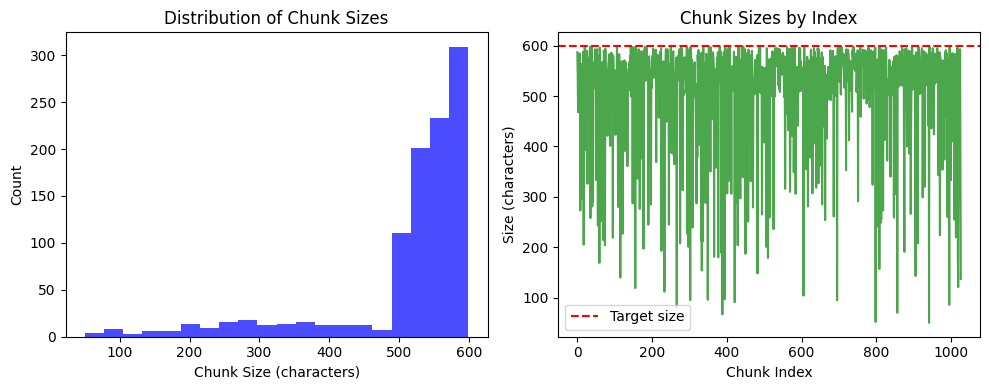


Chunk size statistics:
  Min: 50 chars
  Max: 599 chars
  Mean: 512 chars
  Target: 600 chars


## Vector Store Management

### Creating FAISS Vector Store

Processing 1027 chunks...
FAISS index saved to: ./data/faiss_index
Vector store created successfully


## Building RAG Pipeline

2025-07-30 16:22:39,319 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:22:39,350 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:22:39,350 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:22:39,351 - factories.retriever - INFO - Successfully created hybrid retriever
Created hybrid retriever
2025-07-30 16:22:39,351 - factories.generator - INFO - Created OpenAI generator with model gpt-4o-mini
2025-07-30 16:22:39,352 - factories.generator - INFO - Successfully created openai generator
Created openai generator
Built linear pipeline


Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

### Query: What should I do if my file size exceeds the 4GB limit?

2025-07-30 16:22:39,354 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:22:39,385 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:22:39,386 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:22:39,386 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** The provided context does not contain any information regarding what to do if a file size exceeds the 4GB limit. Therefore, I cannot provide an answer to that question based on the available information.


⏱️ Response time: 1.90s
📄 Retrieved 14 contexts
2025-07-30 16:22:48,360 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  12%|█▎        | 1/8 [00:09<01:03,  9.01s/it]

### Query: How should I sample new data without biasing results?

2025-07-30 16:22:48,369 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:22:48,407 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:22:48,407 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:22:48,407 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** To sample new data without biasing results, consider the following guidelines based on the provided context:

- **Use of Covariates**: Since new users won’t have pre-experiment data, leverage covariates like demographics if possible. This helps in adjusting for differences that could bias results.
  
- **CUPED Methodology**: If the experiment includes both new and established users, apply the CUPED method only to users with pre-experiment data. This allows for better variance reduction and more reliable results.

- **Blind Analyses**: Conduct analyses without knowing which group is the control or treatment. This helps maintain objectivity and reduces bias in interpreting results.

- **Maintain Skepticism**: Approach test results critically, especially if outcomes are unexpectedly positive. This mindset helps avoid human bias and ensures a more objective analysis.

These practices can help ensure that the sampling of new data does not introduce bias into the results.


⏱️ Response time: 5.54s
📄 Retrieved 13 contexts
2025-07-30 16:23:17,030 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  25%|██▌       | 2/8 [00:37<02:03, 20.58s/it]

### Query: What is Type I error (α), and how does it affect my experiment?

2025-07-30 16:23:17,042 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:23:17,080 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:23:17,080 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:23:17,080 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** Type I error (α), also known as a false positive, occurs when a null hypothesis is incorrectly rejected when it is actually true. This means that the test suggests there is an effect or difference when there is none. 

Key points about Type I error (α) and its impact on experiments:

- **Definition**: Type I error is the erroneous rejection of a true null hypothesis. It is sometimes referred to as an error of commission.
- **Significance Level**: The significance level (α) is the probability of committing a Type I error. A common value for α is set at 0.05, indicating a 5% chance of incorrectly rejecting the null hypothesis.
- **Impact on Experiments**:
  - If a Type I error occurs, it can lead to false conclusions about the effectiveness of a treatment or intervention, potentially resulting in misguided decisions based on incorrect data.
  - The lower the significance level (closer to 0), the lower the probability of a Type I error, but this may increase the probability of a Type II error (false negative).

In summary, Type I error can significantly affect the validity of experimental results by leading to incorrect conclusions about the presence of an effect or difference.


⏱️ Response time: 5.22s
📄 Retrieved 12 contexts
2025-07-30 16:23:47,719 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  38%|███▊      | 3/8 [01:08<02:05, 25.19s/it]

### Query: What effect does my chosen alpha (0.05) have on false positives here?

2025-07-30 16:23:47,725 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:23:47,760 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:23:47,760 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:23:47,761 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** Choosing an alpha level of 0.05 has the following effects on false positives:

- **Probability of False Positives**: An alpha level of 0.05 means there is a 5% chance of committing a type I error, which is a false positive. This indicates that there is a 95% chance that the null hypothesis is correct and that the treatment is no better than the control.
- **Balance with Type II Error**: Lowering the alpha level can reduce the probability of false positives but increases the probability of type II errors (false negatives). The closer the alpha is to 0, the lower the probability of a type I error, but this also raises the risk of type II errors.

In summary, an alpha of 0.05 represents a commonly accepted balance where there is a controlled risk of false positives while maintaining a reasonable chance of detecting true effects.


⏱️ Response time: 4.23s
📄 Retrieved 12 contexts
2025-07-30 16:24:14,684 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  50%|█████     | 4/8 [01:35<01:43, 25.89s/it]

### Query: What is CUPED and how does it improve my experiment analysis?

2025-07-30 16:24:14,697 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:24:14,735 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:24:14,735 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:24:14,735 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** CUPED, which stands for Controlled-experiment Using Pre-Experiment Data, is a statistical modeling technique that enhances the speed and accuracy of experimentation programs. It was introduced by Microsoft in 2013 and is increasingly recognized in online experimentation.

### How CUPED Improves Experiment Analysis:

- **Variance Reduction**: CUPED incorporates pre-experiment metrics to adjust and refine estimates from ongoing experiments, thereby reducing unwanted variability (noise) in the data. This leads to:
  - Enhanced statistical power and precision of experimental results.
  - Improved ability to detect true treatment effects that may be obscured by randomness.

- **Contextual Understanding**: By analyzing both current and historical data, CUPED provides a richer contextual understanding of user behavior, which aids in making more informed decisions.

- **Efficiency in Experimentation**: 
  - CUPED can significantly reduce the sample sizes needed for experiments, allowing for quicker turnarounds and faster iterations.
  - This efficiency is particularly beneficial in fast-paced environments where time-to-market is critical.

- **Robust Mechanism for Decision-Making**: It empowers analysts by providing a structured approach to improving statistical estimates, leading to more reliable conclusions from experimental data.

In summary, CUPED is a powerful tool that leverages historical data to improve the accuracy and efficiency of experiment analysis, making it essential for data-driven decision-making in software development and data-heavy industries.


⏱️ Response time: 6.29s
📄 Retrieved 12 contexts
2025-07-30 16:24:48,441 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  62%|██████▎   | 5/8 [02:09<01:26, 28.73s/it]

### Query: How can I validate that CUPED adjustment improved sensitivity in my current dataset?

2025-07-30 16:24:48,451 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:24:48,491 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:24:48,492 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:24:48,492 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** To validate that CUPED adjustment improved sensitivity in your current dataset, you can follow these steps based on the context provided:

- **Compare Results Before and After CUPED**: Analyze the experimental results both with and without CUPED adjustments. Look for differences in the statistical power and precision of the outcomes.
  
- **Examine Confidence Intervals**: CUPED is known for tightening confidence intervals. Check if the confidence intervals for your metrics have become narrower after applying CUPED, which indicates improved sensitivity.

- **Assess Variance Reduction**: Evaluate the variance in your outcome metric before and after applying CUPED. A significant reduction in variance suggests that CUPED has effectively reduced noise in the data.

- **Check for True Treatment Effects**: Determine if CUPED has enabled the detection of true treatment effects that were previously obscured by randomness. This can be assessed by comparing the significance of results before and after applying CUPED.

- **Use Historical Data Correlation**: Ensure that the historical data used in CUPED is correlated with the current outcome metric. This correlation is crucial for CUPED's effectiveness in improving sensitivity.

By following these steps, you can validate the effectiveness of CUPED adjustments in enhancing the sensitivity of your dataset.


⏱️ Response time: 7.12s
📄 Retrieved 13 contexts
2025-07-30 16:25:24,727 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  75%|███████▌  | 6/8 [02:45<01:02, 31.30s/it]

### Query: If the QQ plot for an outcome metric deviates significantly from the diagonal line, what does this imply about the data distribution?

2025-07-30 16:25:24,733 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:25:24,771 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:25:24,772 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:25:24,772 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** If the Q-Q plot for an outcome metric deviates significantly from the diagonal line (identity line), it implies that the data distribution is likely not normally distributed. Specifically:

- Points that curve away from the line suggest that the data does not follow a normal distribution.
- If the points are above or below the line, it indicates that the distributions being compared differ.

As stated in the context, "If the points curve away from the line (especially at the tails) then the data is likely not normally distributed."


⏱️ Response time: 3.00s
📄 Retrieved 12 contexts
2025-07-30 16:25:39,981 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  88%|████████▊ | 7/8 [03:00<00:26, 26.05s/it]

### Query: What if Q-Q plots deviate from diagonal in my revenue data?

2025-07-30 16:25:39,989 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:25:40,053 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:25:40,054 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:25:40,055 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** If Q–Q plots deviate from the diagonal line (y = x) in your revenue data, it suggests the following:

- **Distribution Differences**: The distributions being compared are not similar. Specifically:
  - If the points in the Q–Q plot lie below the line y = x, it indicates that the distribution plotted on the horizontal axis is more dispersed than the distribution on the vertical axis.
  - Conversely, if the points lie above the line y = x, it indicates that the distribution on the vertical axis is more dispersed than the one on the horizontal axis.

- **Skewness and Tails**: The Q–Q plot may also exhibit an arced or S-shaped pattern, which suggests that one of the distributions is more skewed than the other or that one has heavier tails than the other.

These observations can help in understanding the underlying characteristics of your revenue data compared to a theoretical distribution.


⏱️ Response time: 4.29s
📄 Retrieved 13 contexts
2025-07-30 16:26:01,907 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating: 100%|██████████| 8/8 [03:22<00:00, 25.32s/it]


Configuration 4/16
Variant: {'loader': 'pdf', 'chunker': 'semantic_600', 'embedding': 'openai_text-embedding-3-small', 'storage': 'faiss', 'retrieval': 'hybrid_k7', 'generation': 'openai_gpt-4o-mini'}
2025-07-30 16:26:01,922 - system.rag_system - INFO - Initializing RAG system components


## Initializing RAG System Components

2025-07-30 16:26:01,926 - system.rag_system - INFO - Document processor initialized
✓ Document processor initialized
Initialized embeddings with model: text-embedding-3-small
2025-07-30 16:26:01,945 - system.rag_system - INFO - Vector store manager initialized
✓ Vector store manager initialized
2025-07-30 16:26:01,946 - system.rag_system - INFO - Component factories initialized
✓ Component factories initialized
2025-07-30 16:26:01,946 - system.rag_system - INFO - Pipeline builder initialized
✓ Pipeline builder initialized
2025-07-30 16:26:01,963 - system.rag_system - INFO - Evaluation systems initialized
✓ Evaluation systems initialized
2025-07-30 16:26:01,964 - document_processing.processor - INFO - Loading PDFs from directory: documents


Ignoring wrong pointing object 7 0 (offset 0)
Ignoring wrong pointing object 9 0 (offset 0)
Ignoring wrong pointing object 54 0 (offset 0)
Ignoring wrong pointing object 236 0 (offset 0)
Ignoring wrong pointing object 670 0 (offset 0)
Ignoring wrong pointing object 1329 0 (offset 0)
Ignoring wrong pointing object 1330 0 (offset 0)


2025-07-30 16:26:08,211 - document_processing.processor - INFO - Loaded 224 document pages


### Loading Summary

Loaded 224 document pages


#### First Document Preview:

Source: documents/kb.pdf
Page: 0
Content preview: RAG KNOWLEDGE BASE 
 
Explaining the Streamlit platform 
 
1. Experiment design tab: calculating sample sizes before running an 
experiment 
Purpose: Before launching an A/B test, we want to calculate...
2025-07-30 16:26:08,213 - document_processing.processor - WARNING - Semantic chunking not yet implemented, falling back to recursive
2025-07-30 16:26:08,232 - document_processing.processor - INFO - Created 1027 chunks with recursive strategy


### Chunking Summary

Created 1027 chunks from 224 documents
Average chunk size: 512 characters


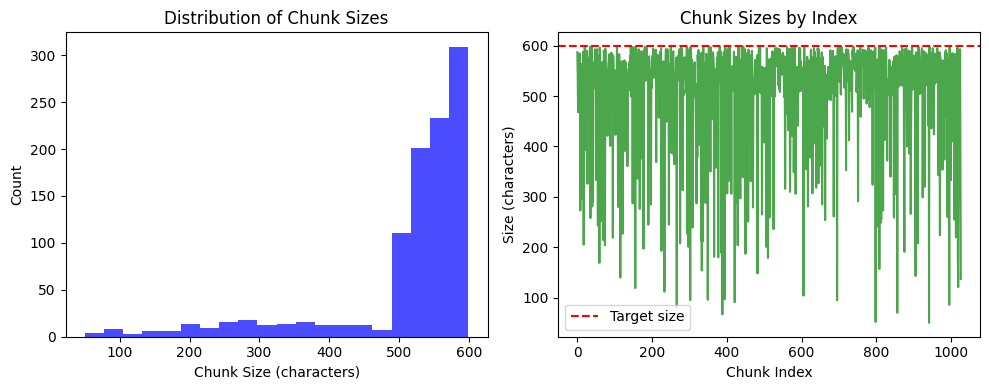


Chunk size statistics:
  Min: 50 chars
  Max: 599 chars
  Mean: 512 chars
  Target: 600 chars


## Vector Store Management

### Creating FAISS Vector Store

Processing 1027 chunks...
FAISS index saved to: ./data/faiss_index
Vector store created successfully


## Building RAG Pipeline

2025-07-30 16:26:13,412 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:26:13,446 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:26:13,447 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:26:13,447 - factories.retriever - INFO - Successfully created hybrid retriever
Created hybrid retriever
2025-07-30 16:26:13,448 - factories.generator - INFO - Created OpenAI generator with model gpt-4o-mini
2025-07-30 16:26:13,448 - factories.generator - INFO - Successfully created openai generator
Created openai generator
Built linear pipeline


Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

### Query: What should I do if my file size exceeds the 4GB limit?

2025-07-30 16:26:13,450 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:26:13,484 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:26:13,484 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:26:13,485 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** The provided context does not contain any information regarding what to do if a file size exceeds the 4GB limit. Therefore, I cannot provide an answer to that question based on the available information.


⏱️ Response time: 2.12s
📄 Retrieved 14 contexts
2025-07-30 16:26:21,758 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  12%|█▎        | 1/8 [00:08<00:58,  8.31s/it]

### Query: How should I sample new data without biasing results?

2025-07-30 16:26:21,765 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:26:21,803 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:26:21,803 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:26:21,803 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** To sample new data without biasing results, consider the following guidelines based on the provided context:

- **Use of Covariates**: Since new users won’t have pre-experiment data, leverage covariates like demographics if possible. This helps in analyzing the data without bias.
- **CUPED Methodology**: If the experiment includes both new and established users, apply the CUPED method only to users with pre-experiment data. This allows for a more accurate analysis by controlling for variance.
- **Blind Analyses**: Conduct analyses without knowing which group is the control or treatment to maintain objectivity and reduce bias.
- **Maintain Skepticism**: Approach test results critically, especially if outcomes are unexpectedly positive, to avoid human bias.

These practices help ensure that the sampling and analysis of new data are conducted in a way that minimizes bias and enhances the reliability of the results.


⏱️ Response time: 4.85s
📄 Retrieved 13 contexts
2025-07-30 16:26:48,402 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  25%|██▌       | 2/8 [00:34<01:54, 19.10s/it]

### Query: What is Type I error (α), and how does it affect my experiment?

2025-07-30 16:26:48,414 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:26:48,453 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:26:48,454 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:26:48,454 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** Type I error (α), also known as a false positive, occurs when a null hypothesis is incorrectly rejected when it is actually true. This means that the test concludes there is an effect or difference when there is none. 

Key points about Type I error (α) and its effects on experiments:

- **Definition**: Type I error is the erroneous rejection of a true null hypothesis. It is sometimes referred to as an error of commission.
- **Significance Level**: The significance level (α) is the probability of committing a Type I error. A common value for α is set at 0.05, indicating a 5% chance of incorrectly rejecting the null hypothesis.
- **Impact on Experiments**:
  - If a Type I error occurs, it can lead to false conclusions about the effectiveness of a treatment or intervention, potentially resulting in misguided decisions based on incorrect data.
  - Lowering the significance level (closer to 0) reduces the probability of a Type I error but may increase the probability of a Type II error (false negative).

In summary, Type I error can significantly affect the validity of experimental results by leading to incorrect conclusions about the presence of an effect or difference when none exists.


⏱️ Response time: 5.19s
📄 Retrieved 12 contexts
2025-07-30 16:27:17,844 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  38%|███▊      | 3/8 [01:04<01:59, 23.82s/it]

### Query: What effect does my chosen alpha (0.05) have on false positives here?

2025-07-30 16:27:17,852 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:27:17,892 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:27:17,893 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:27:17,893 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** Choosing an alpha level of 0.05 has the following effects on false positives:

- **Probability of False Positives**: An alpha level of 0.05 means there is a 5% chance of committing a type I error, which is a false positive. This indicates that if the null hypothesis is true, there is a 5% probability of incorrectly rejecting it.
- **Common Acceptance**: This level is commonly accepted as a balance between the risk of false positives and false negatives. As stated, "a happy middle ground, and commonly accepted level for α is 0.05."
- **Impact on Type II Errors**: Lowering the alpha level would decrease the probability of false positives but would increase the probability of type II errors (false negatives), as noted in the context: "The closer to 0, the lower the probability of a type I error/false positive, but the higher the probability of a type II error/false negative."

In summary, an alpha of 0.05 allows for a controlled risk of false positives while balancing the potential for false negatives.


⏱️ Response time: 5.53s
📄 Retrieved 12 contexts
2025-07-30 16:27:41,364 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  50%|█████     | 4/8 [01:27<01:34, 23.70s/it]

### Query: What is CUPED and how does it improve my experiment analysis?

2025-07-30 16:27:41,369 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:27:41,409 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:27:41,410 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:27:41,411 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** CUPED, which stands for Controlled-experiment Using Pre-Experiment Data, is a statistical modeling technique that enhances the speed and accuracy of experimentation programs. It was introduced by Microsoft in 2013 and is increasingly recognized in online experimentation.

### How CUPED Improves Experiment Analysis:

- **Variance Reduction**: CUPED incorporates pre-experiment metrics to adjust ongoing experiment estimates, which helps mitigate noise (unwanted variability) in the data. This leads to:
  - Enhanced statistical power and precision of experimental results.
  - Improved ability to detect true treatment effects that might be obscured by randomness.

- **Contextual Understanding**: By analyzing both current and historical data, CUPED provides a richer contextual understanding of user behavior, allowing for more accurate interpretations and decisions based on the data.

- **Sample Size Efficiency**: CUPED can significantly reduce the sample sizes needed for experiments, leading to quicker turnarounds and enabling teams to iterate rapidly. This is particularly beneficial in fast-paced environments.

- **Robust Mechanism for Decision-Making**: It empowers analysts to draw reliable conclusions from experiments, thus improving the overall efficiency of data-driven decision-making processes.

In summary, CUPED is a powerful tool for improving the reliability and efficiency of experiment analysis by leveraging historical data to reduce variance and enhance the clarity of findings.


⏱️ Response time: 4.83s
📄 Retrieved 12 contexts
2025-07-30 16:28:14,484 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  62%|██████▎   | 5/8 [02:01<01:21, 27.10s/it]

### Query: How can I validate that CUPED adjustment improved sensitivity in my current dataset?

2025-07-30 16:28:14,490 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:28:14,539 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:28:14,541 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:28:14,542 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** To validate that CUPED adjustment improved sensitivity in your current dataset, you can follow these steps based on the context provided:

- **Compare Results Before and After CUPED**: Analyze the experimental results both with and without CUPED adjustments. Look for differences in the statistical power and precision of the estimates.
  
- **Check for Noise Reduction**: Assess whether the CUPED adjustments have successfully mitigated noise in the data, which is indicated by clearer and more reliable results.

- **Evaluate Confidence Intervals**: Examine the tightening of confidence intervals after applying CUPED. A reduction in the width of these intervals suggests improved sensitivity.

- **Use Historical Data Correlation**: Ensure that the pre-experiment metrics used in CUPED are correlated with the outcome metric. This correlation is crucial for the effectiveness of CUPED in enhancing sensitivity.

- **Monitor Variance Reduction**: Look for a decrease in variance of the outcome metric post-CUPED application, particularly for high-variance metrics like revenue per visitor or average order value.

By following these steps, you can effectively validate the impact of CUPED adjustments on the sensitivity of your dataset.


⏱️ Response time: 4.73s
📄 Retrieved 13 contexts
2025-07-30 16:28:45,137 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  75%|███████▌  | 6/8 [02:31<00:56, 28.31s/it]

### Query: If the QQ plot for an outcome metric deviates significantly from the diagonal line, what does this imply about the data distribution?

2025-07-30 16:28:45,143 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:28:45,186 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:28:45,186 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:28:45,187 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** If the Q-Q plot for an outcome metric deviates significantly from the diagonal line (identity line y = x), it implies that the data distribution is not normal. Specifically:

- If the points curve away from the line, especially at the tails, it indicates that the data is likely not normally distributed.
- A flatter trend in the Q-Q plot suggests that the distribution plotted on the vertical axis is more dispersed than the distribution plotted on the horizontal axis, while a steeper trend indicates the opposite.
- An arced or S-shaped Q-Q plot suggests that one of the distributions is more skewed than the other or has heavier tails.

In summary, significant deviation from the diagonal line indicates differences in distribution characteristics, suggesting non-normality.


⏱️ Response time: 3.65s
📄 Retrieved 12 contexts
2025-07-30 16:29:07,854 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  88%|████████▊ | 7/8 [02:54<00:26, 26.48s/it]

### Query: What if Q-Q plots deviate from diagonal in my revenue data?

2025-07-30 16:29:07,865 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:29:07,904 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:29:07,904 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:29:07,905 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** If Q–Q plots deviate from the diagonal line (y = x) in your revenue data, it suggests the following:

- **Distribution Characteristics**:
  - If the points in the Q–Q plot are below the line, it indicates that the distribution plotted on the horizontal axis is more dispersed than the distribution on the vertical axis.
  - Conversely, if the points are above the line, it suggests that the distribution on the vertical axis is more dispersed than the one on the horizontal axis.

- **Skewness and Tails**:
  - A Q–Q plot that is arced or S-shaped indicates that one of the distributions is more skewed than the other or that one has heavier tails than the other.

These deviations provide insights into how the revenue data compares to the theoretical distribution being used for the analysis.


⏱️ Response time: 4.15s
📄 Retrieved 13 contexts
2025-07-30 16:29:29,168 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating: 100%|██████████| 8/8 [03:15<00:00, 24.47s/it]


Configuration 5/16
Variant: {'loader': 'pdf', 'chunker': 'semantic_600', 'embedding': 'openai_text-embedding-3-small', 'storage': 'faiss', 'retrieval': 'hybrid_k7', 'generation': 'openai_gpt-4o-mini'}
2025-07-30 16:29:29,182 - system.rag_system - INFO - Initializing RAG system components


## Initializing RAG System Components

2025-07-30 16:29:29,184 - system.rag_system - INFO - Document processor initialized
✓ Document processor initialized
Initialized embeddings with model: text-embedding-3-small
2025-07-30 16:29:29,205 - system.rag_system - INFO - Vector store manager initialized
✓ Vector store manager initialized
2025-07-30 16:29:29,206 - system.rag_system - INFO - Component factories initialized
✓ Component factories initialized
2025-07-30 16:29:29,206 - system.rag_system - INFO - Pipeline builder initialized
✓ Pipeline builder initialized
2025-07-30 16:29:29,222 - system.rag_system - INFO - Evaluation systems initialized
✓ Evaluation systems initialized
2025-07-30 16:29:29,223 - document_processing.processor - INFO - Loading PDFs from directory: documents


Ignoring wrong pointing object 7 0 (offset 0)
Ignoring wrong pointing object 9 0 (offset 0)
Ignoring wrong pointing object 54 0 (offset 0)
Ignoring wrong pointing object 236 0 (offset 0)
Ignoring wrong pointing object 670 0 (offset 0)
Ignoring wrong pointing object 1329 0 (offset 0)
Ignoring wrong pointing object 1330 0 (offset 0)


2025-07-30 16:29:36,066 - document_processing.processor - INFO - Loaded 224 document pages


### Loading Summary

Loaded 224 document pages


#### First Document Preview:

Source: documents/kb.pdf
Page: 0
Content preview: RAG KNOWLEDGE BASE 
 
Explaining the Streamlit platform 
 
1. Experiment design tab: calculating sample sizes before running an 
experiment 
Purpose: Before launching an A/B test, we want to calculate...
2025-07-30 16:29:36,068 - document_processing.processor - WARNING - Semantic chunking not yet implemented, falling back to recursive
2025-07-30 16:29:36,087 - document_processing.processor - INFO - Created 1027 chunks with recursive strategy


### Chunking Summary

Created 1027 chunks from 224 documents
Average chunk size: 512 characters


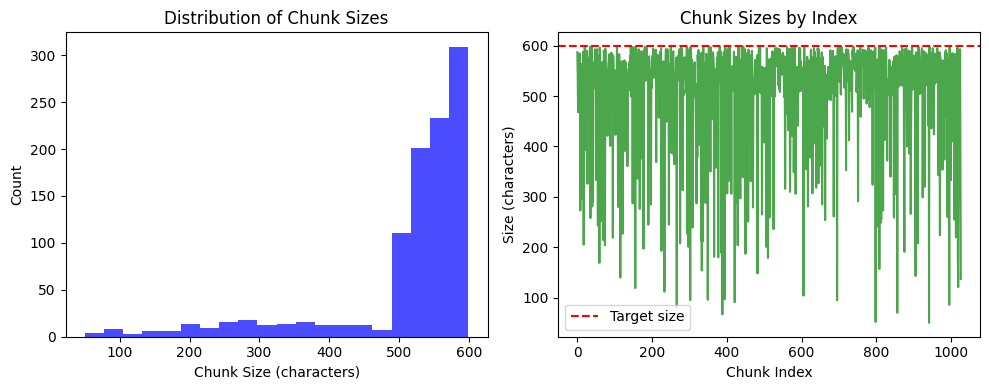


Chunk size statistics:
  Min: 50 chars
  Max: 599 chars
  Mean: 512 chars
  Target: 600 chars


## Vector Store Management

### Creating FAISS Vector Store

Processing 1027 chunks...
FAISS index saved to: ./data/faiss_index
Vector store created successfully


## Building RAG Pipeline

2025-07-30 16:29:40,630 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:29:40,663 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:29:40,663 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:29:40,664 - factories.retriever - INFO - Successfully created hybrid retriever
Created hybrid retriever
2025-07-30 16:29:40,664 - factories.generator - INFO - Created OpenAI generator with model gpt-4o-mini
2025-07-30 16:29:40,664 - factories.generator - INFO - Successfully created openai generator
Created openai generator
Built linear pipeline


Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

### Query: What should I do if my file size exceeds the 4GB limit?

2025-07-30 16:29:40,666 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:29:40,699 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:29:40,699 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:29:40,699 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** The provided context does not contain any information regarding what to do if a file size exceeds the 4GB limit. Therefore, I cannot provide an answer to that question based on the available information.


⏱️ Response time: 1.81s
📄 Retrieved 14 contexts
2025-07-30 16:29:49,384 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  12%|█▎        | 1/8 [00:08<01:01,  8.72s/it]

### Query: How should I sample new data without biasing results?

2025-07-30 16:29:49,392 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:29:49,428 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:29:49,429 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:29:49,429 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** To sample new data without biasing results, consider the following guidelines based on the provided context:

- **Use of Covariates**: For experiments involving new users who lack pre-experiment data, leverage covariates like demographics if possible. This helps in controlling for potential biases.
  
- **CUPED Methodology**: If the experiment includes both new and established users, apply the CUPED method only to users with pre-experiment data. This approach can help reduce variance and improve the reliability of results.

- **Conduct Blind Analyses**: Analyze data without knowing which group is the control or treatment to maintain objectivity and avoid bias.

- **Maintain Skepticism**: Approach test results critically, especially when outcomes are unexpectedly positive, to avoid human bias.

These practices can help ensure that the sampling of new data does not introduce bias into the results.


⏱️ Response time: 4.00s
📄 Retrieved 13 contexts
2025-07-30 16:30:10,960 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  25%|██▌       | 2/8 [00:30<01:37, 16.29s/it]

### Query: What is Type I error (α), and how does it affect my experiment?

2025-07-30 16:30:10,971 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:30:11,009 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:30:11,009 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:30:11,009 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** Type I error (α), also known as a false positive, occurs when a null hypothesis is incorrectly rejected when it is actually true. This means that the test suggests there is an effect or difference when there is none. 

Key points about Type I error (α) and its impact on experiments:

- **Definition**: Type I error is the erroneous rejection of a true null hypothesis. It is sometimes referred to as an error of commission.
- **Significance Level**: The significance level (α) is the probability of committing a Type I error. A common value for α is set at 0.05, indicating a 5% chance of incorrectly rejecting the null hypothesis.
- **Impact on Experiments**:
  - If a Type I error occurs, it can lead to false conclusions about the effectiveness of a treatment or intervention, potentially resulting in misguided decisions based on incorrect data.
  - The closer the significance level is to 0, the lower the probability of a Type I error, but this may increase the probability of a Type II error (false negative).

In summary, Type I error can significantly affect the validity of experimental results by leading to incorrect conclusions about the presence of an effect or difference.


⏱️ Response time: 6.10s
📄 Retrieved 12 contexts
2025-07-30 16:30:44,337 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  38%|███▊      | 3/8 [01:03<02:00, 24.09s/it]

### Query: What effect does my chosen alpha (0.05) have on false positives here?

2025-07-30 16:30:44,351 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:30:44,410 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:30:44,411 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:30:44,411 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** Choosing an alpha level of 0.05 has the following effects on false positives:

- **Probability of False Positives**: An alpha level of 0.05 means there is a 5% chance of committing a type I error, which is a false positive. This indicates that there is a 95% chance that the null hypothesis is correct and that the treatment is no better than the control.
- **Balance with Type II Error**: Lowering the alpha level would decrease the probability of false positives but would increase the probability of type II errors (false negatives). The context states, "The closer to 0, the lower the probability of a type I error/false positive, but the higher the probability of a type II error/false negative."

In summary, setting alpha at 0.05 allows for a controlled risk of false positives while balancing the risk of false negatives.


⏱️ Response time: 4.70s
📄 Retrieved 12 contexts
2025-07-30 16:31:09,207 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  50%|█████     | 4/8 [01:28<01:37, 24.40s/it]

### Query: What is CUPED and how does it improve my experiment analysis?

2025-07-30 16:31:09,220 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:31:09,259 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:31:09,260 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:31:09,260 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** CUPED, which stands for Controlled-experiment Using Pre-Experiment Data, is a statistical modeling technique that enhances the speed and accuracy of experimentation programs. It was introduced by Microsoft in 2013 and is increasingly recognized in online experimentation.

### How CUPED Improves Experiment Analysis:

- **Variance Reduction**: CUPED incorporates pre-experiment metrics to adjust ongoing experiment estimates, thereby reducing noise (unwanted variability) in the data. This leads to:
  - Enhanced statistical power and precision of experimental results.
  - Improved ability to detect true treatment effects that might be obscured by randomness.

- **Contextual Understanding**: By analyzing both current and historical data, CUPED provides a richer contextual understanding of user behavior, which aids in making more informed decisions.

- **Sample Size Efficiency**: CUPED can significantly reduce the sample sizes needed for experiments, allowing for quicker turnarounds and enabling teams to iterate rapidly. This is particularly beneficial in fast-paced environments.

- **Robust Mechanism for Decision-Making**: It empowers analysts with a structured approach to improve statistical estimates, leading to more reliable conclusions from experimental data.

In summary, CUPED is a powerful tool that enhances the reliability and efficiency of experiment analysis by leveraging historical data to reduce variance and improve the clarity of findings.


⏱️ Response time: 5.90s
📄 Retrieved 12 contexts
2025-07-30 16:31:43,816 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  62%|██████▎   | 5/8 [02:03<01:24, 28.08s/it]

### Query: How can I validate that CUPED adjustment improved sensitivity in my current dataset?

2025-07-30 16:31:43,826 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:31:43,864 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:31:43,864 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:31:43,865 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** To validate that CUPED adjustment improved sensitivity in your current dataset, you can follow these steps based on the context provided:

- **Compare Pre- and Post-CUPED Results**: Analyze the experimental results before and after applying CUPED to see if there is an increase in the statistical power and precision of the estimates.
  
- **Examine Confidence Intervals**: Look for tighter confidence intervals in the CUPED-adjusted results, which indicates improved sensitivity. As noted, "this tightening of confidence intervals is what makes CUPED so effective."

- **Assess Variance Reduction**: Evaluate the variance in your outcome metric before and after applying CUPED. The technique is designed to "reduce variance in your outcome metric by using pre-experiment information that’s correlated with the outcome."

- **Check for True Treatment Effects**: Determine if CUPED has enabled the detection of true treatment effects that were previously obscured by randomness, as stated, "the adjustments made by CUPED often lead to detecting true treatment effects that may otherwise be obscured by randomness."

- **Use Statistical Tests**: Conduct statistical tests to compare the sensitivity of the results with and without CUPED adjustments, ensuring that the assumptions of normality hold or applying appropriate transformations if necessary.

By following these steps, you can effectively validate the improvement in sensitivity due to CUPED adjustments in your dataset.


⏱️ Response time: 6.66s
📄 Retrieved 13 contexts
2025-07-30 16:32:18,169 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  75%|███████▌  | 6/8 [02:37<01:00, 30.21s/it]

### Query: If the QQ plot for an outcome metric deviates significantly from the diagonal line, what does this imply about the data distribution?

2025-07-30 16:32:18,181 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:32:18,220 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:32:18,220 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:32:18,221 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** If the Q-Q plot for an outcome metric deviates significantly from the diagonal line (identity line y = x), it implies that the data distribution is not normally distributed. Specifically:

- Points that curve away from the line suggest that the data is likely not normally distributed.
- If the points are above or below the line, it indicates that the distributions differ.

This is important because, as noted, "if the data is not normal, the test might give misleading results."


⏱️ Response time: 2.70s
📄 Retrieved 12 contexts
2025-07-30 16:32:33,828 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  88%|████████▊ | 7/8 [02:53<00:25, 25.45s/it]

### Query: What if Q-Q plots deviate from diagonal in my revenue data?

2025-07-30 16:32:33,839 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:32:33,878 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:32:33,879 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:32:33,879 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** If Q–Q plots deviate from the diagonal line (y = x) in your revenue data, it suggests the following:

- **More Dispersed Distribution**: If the points in the Q–Q plot are below the line, the distribution plotted on the horizontal axis is more dispersed than the distribution plotted on the vertical axis.
- **Steeper Trend**: Conversely, if the points are above the line, the distribution plotted on the vertical axis is more dispersed than the distribution plotted on the horizontal axis.
- **Skewness or Heavier Tails**: An S-shaped or arced pattern in the Q–Q plot indicates that one of the distributions is more skewed than the other or that one distribution has heavier tails than the other.

These deviations provide insights into how the revenue data compares to the theoretical distribution being used for the analysis.


⏱️ Response time: 5.19s
📄 Retrieved 13 contexts
2025-07-30 16:32:54,238 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating: 100%|██████████| 8/8 [03:13<00:00, 24.20s/it]


Configuration 6/16
Variant: {'loader': 'pdf', 'chunker': 'semantic_600', 'embedding': 'openai_text-embedding-3-small', 'storage': 'faiss', 'retrieval': 'hybrid_k7', 'generation': 'openai_gpt-4o-mini'}
2025-07-30 16:32:54,248 - system.rag_system - INFO - Initializing RAG system components


## Initializing RAG System Components

2025-07-30 16:32:54,249 - system.rag_system - INFO - Document processor initialized
✓ Document processor initialized
Initialized embeddings with model: text-embedding-3-small
2025-07-30 16:32:54,268 - system.rag_system - INFO - Vector store manager initialized
✓ Vector store manager initialized
2025-07-30 16:32:54,268 - system.rag_system - INFO - Component factories initialized
✓ Component factories initialized
2025-07-30 16:32:54,269 - system.rag_system - INFO - Pipeline builder initialized
✓ Pipeline builder initialized
2025-07-30 16:32:54,286 - system.rag_system - INFO - Evaluation systems initialized
✓ Evaluation systems initialized
2025-07-30 16:32:54,287 - document_processing.processor - INFO - Loading PDFs from directory: documents


Ignoring wrong pointing object 7 0 (offset 0)
Ignoring wrong pointing object 9 0 (offset 0)
Ignoring wrong pointing object 54 0 (offset 0)
Ignoring wrong pointing object 236 0 (offset 0)
Ignoring wrong pointing object 670 0 (offset 0)
Ignoring wrong pointing object 1329 0 (offset 0)
Ignoring wrong pointing object 1330 0 (offset 0)


2025-07-30 16:33:00,958 - document_processing.processor - INFO - Loaded 224 document pages


### Loading Summary

Loaded 224 document pages


#### First Document Preview:

Source: documents/kb.pdf
Page: 0
Content preview: RAG KNOWLEDGE BASE 
 
Explaining the Streamlit platform 
 
1. Experiment design tab: calculating sample sizes before running an 
experiment 
Purpose: Before launching an A/B test, we want to calculate...
2025-07-30 16:33:00,960 - document_processing.processor - WARNING - Semantic chunking not yet implemented, falling back to recursive
2025-07-30 16:33:00,980 - document_processing.processor - INFO - Created 1027 chunks with recursive strategy


### Chunking Summary

Created 1027 chunks from 224 documents
Average chunk size: 512 characters


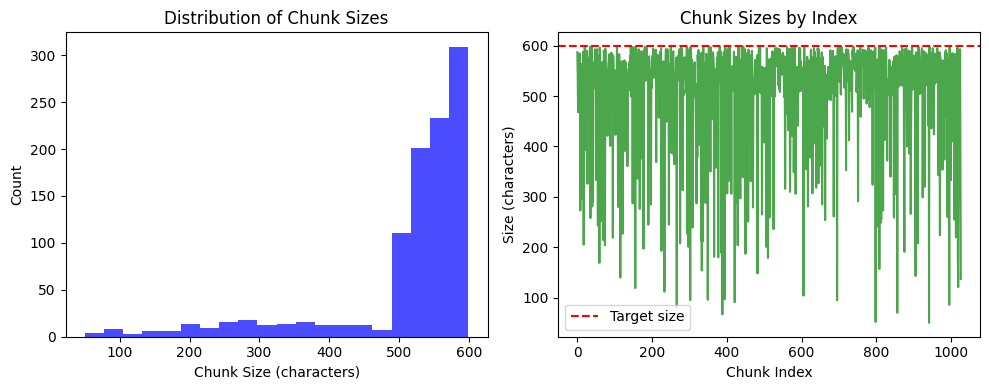


Chunk size statistics:
  Min: 50 chars
  Max: 599 chars
  Mean: 512 chars
  Target: 600 chars


## Vector Store Management

### Creating FAISS Vector Store

Processing 1027 chunks...
FAISS index saved to: ./data/faiss_index
Vector store created successfully


## Building RAG Pipeline

2025-07-30 16:33:07,738 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:33:07,772 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:33:07,773 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:33:07,773 - factories.retriever - INFO - Successfully created hybrid retriever
Created hybrid retriever
2025-07-30 16:33:07,774 - factories.generator - INFO - Created OpenAI generator with model gpt-4o-mini
2025-07-30 16:33:07,774 - factories.generator - INFO - Successfully created openai generator
Created openai generator
Built linear pipeline


Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

### Query: What should I do if my file size exceeds the 4GB limit?

2025-07-30 16:33:07,777 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:33:07,814 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:33:07,814 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:33:07,814 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** The provided context does not contain any information regarding what to do if a file size exceeds the 4GB limit. Therefore, I cannot provide an answer to that question based on the available information.


⏱️ Response time: 2.20s
📄 Retrieved 14 contexts
2025-07-30 16:33:16,308 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  12%|█▎        | 1/8 [00:08<00:59,  8.54s/it]

### Query: How should I sample new data without biasing results?

2025-07-30 16:33:16,312 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:33:16,350 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:33:16,350 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:33:16,351 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** To sample new data without biasing results, consider the following guidelines based on the provided context:

- **Use of Covariates**: Since new users won’t have pre-experiment data, leverage covariates like demographics if possible. This helps in analyzing the data without introducing bias.
  
- **CUPED Method**: If your experiment includes both new and established users, apply the CUPED method only to users with pre-experiment data. This approach allows you to split the population based on whether they have historical data or not, thus reducing bias in the analysis.

- **Blind Analyses**: Conduct analyses without knowing which group is the control or treatment. This helps maintain objectivity and reduces the risk of bias in interpreting results.

- **Maintain Skepticism**: Approach test results critically, especially when outcomes are unexpectedly positive. This mindset helps avoid human bias and ensures a more objective analysis.

These strategies can help ensure that the sampling of new data does not lead to biased results.


⏱️ Response time: 4.83s
📄 Retrieved 13 contexts
2025-07-30 16:33:42,232 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  25%|██▌       | 2/8 [00:34<01:52, 18.77s/it]

### Query: What is Type I error (α), and how does it affect my experiment?

2025-07-30 16:33:42,239 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:33:42,278 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:33:42,279 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:33:42,279 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** Type I error (α), also known as a false positive, occurs when a null hypothesis is incorrectly rejected when it is actually true. This means that the test suggests there is an effect or difference when, in reality, there is none. 

Key points regarding Type I error (α) and its impact on experiments:

- **Definition**: Type I error is the erroneous rejection of a true null hypothesis. It is sometimes referred to as an error of commission.
- **Significance Level**: The significance level (α) is the probability of committing a Type I error. A common value for α is set at 0.05, indicating a 5% chance of incorrectly rejecting the null hypothesis.
- **Impact on Experiment**:
  - If α is too high, there is a greater risk of concluding that a treatment or effect exists when it does not, leading to potentially misleading results.
  - Lowering α reduces the likelihood of Type I errors but may increase the risk of Type II errors (false negatives), where a true effect is missed.

In summary, Type I error affects experiments by introducing the risk of false conclusions about the presence of effects or differences, which can lead to incorrect decisions based on the experimental data.


⏱️ Response time: 5.37s
📄 Retrieved 12 contexts
2025-07-30 16:34:10,820 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  38%|███▊      | 3/8 [01:03<01:56, 23.25s/it]

### Query: What effect does my chosen alpha (0.05) have on false positives here?

2025-07-30 16:34:10,832 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:34:10,873 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:34:10,874 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:34:10,874 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** Choosing an alpha level of 0.05 has the following effects on false positives:

- **Probability of False Positives**: An alpha level of 0.05 means there is a 5% chance of committing a type I error, which is a false positive. This indicates that there is a 95% chance that the null hypothesis is correct and that the treatment is no better than the control.
- **Balance with Type II Error**: Lowering the alpha level would decrease the probability of false positives but would increase the probability of type II errors (false negatives). This creates a trade-off between the two types of errors.

As stated in the context, "the closer to 0, the lower the probability of a type I error/false positive, but the higher the probability of a type II error/false negative." Thus, an alpha of 0.05 is a commonly accepted middle ground for balancing these risks.


⏱️ Response time: 4.24s
📄 Retrieved 12 contexts
2025-07-30 16:34:32,980 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  50%|█████     | 4/8 [01:25<01:31, 22.82s/it]

### Query: What is CUPED and how does it improve my experiment analysis?

2025-07-30 16:34:32,993 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:34:33,204 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:34:33,205 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:34:33,205 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** CUPED, which stands for Controlled-experiment Using Pre-Experiment Data, is a statistical modeling technique that enhances the speed and accuracy of experimentation programs. It was coined by Microsoft in 2013 and is increasingly recognized in online experimentation.

### How CUPED Improves Experiment Analysis:

- **Variance Reduction**: CUPED incorporates pre-experiment metrics to adjust and refine estimates from ongoing experiments, thereby reducing unwanted variability (noise) in the data. This leads to:
  - Enhanced statistical power and precision of experimental results.
  - Improved ability to detect true treatment effects that may be obscured by randomness.

- **Contextual Understanding**: By analyzing both current and historical data, CUPED provides a richer contextual understanding of user behavior, which helps in making more informed decisions.

- **Efficiency in Experimentation**: 
  - CUPED can significantly reduce the sample sizes needed for experiments, allowing for quicker turnarounds and faster iterations.
  - This efficiency is particularly beneficial in fast-paced environments where time-to-market is critical.

- **Robust Mechanism for Decision-Making**: The adjustments made by CUPED lead to more accurate interpretations of experimental findings, empowering analysts to draw reliable conclusions and make confident decisions based on their data.

In summary, CUPED is a powerful tool for improving the reliability and efficiency of experiment analysis by leveraging historical data to reduce variance and enhance the clarity of results.


⏱️ Response time: 6.51s
📄 Retrieved 12 contexts
2025-07-30 16:35:10,418 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  62%|██████▎   | 5/8 [02:02<01:24, 28.09s/it]

### Query: How can I validate that CUPED adjustment improved sensitivity in my current dataset?

2025-07-30 16:35:10,433 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:35:10,475 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:35:10,476 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:35:10,476 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** To validate that CUPED adjustment improved sensitivity in your current dataset, you can follow these steps based on the context provided:

- **Compare Results Before and After CUPED**: Analyze the experimental results both with and without CUPED adjustments. Look for differences in the statistical power and precision of the estimates.
  
- **Examine Confidence Intervals**: CUPED tightens confidence intervals, which can indicate improved sensitivity. Check if the confidence intervals for the treatment effects are narrower after applying CUPED.

- **Assess Variance Reduction**: Since CUPED is designed to reduce variance in your outcome metric, evaluate the variance of your results before and after applying CUPED. A reduction in variance suggests improved sensitivity.

- **Check for True Treatment Effects**: Determine if CUPED adjustments have led to the detection of true treatment effects that were previously obscured by noise. This can be assessed by comparing the significance of results pre- and post-CUPED.

- **Utilize Historical Data Correlation**: Ensure that the historical data used in CUPED is correlated with the current outcome metric, as this correlation is crucial for the effectiveness of the adjustment.

By following these steps, you can validate the effectiveness of CUPED in enhancing the sensitivity of your dataset.


⏱️ Response time: 6.31s
📄 Retrieved 13 contexts
2025-07-30 16:35:48,986 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  75%|███████▌  | 6/8 [02:41<01:03, 31.65s/it]

### Query: If the QQ plot for an outcome metric deviates significantly from the diagonal line, what does this imply about the data distribution?

2025-07-30 16:35:48,994 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:35:49,061 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:35:49,062 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:35:49,062 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** If the Q-Q plot for an outcome metric deviates significantly from the diagonal line (identity line y = x), it implies that the data distribution is not normal. Specifically:

- Points that curve away from the line suggest that the data is likely not normally distributed.
- If the points are above or below the line, it indicates that the distributions differ.

As stated in the context, "If the points curve away from the line (especially at the tails) then the data is likely not normally distributed."


⏱️ Response time: 3.27s
📄 Retrieved 12 contexts
2025-07-30 16:36:08,596 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  88%|████████▊ | 7/8 [03:00<00:27, 27.71s/it]

### Query: What if Q-Q plots deviate from diagonal in my revenue data?

2025-07-30 16:36:08,602 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:36:08,642 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:36:08,642 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:36:08,643 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** If Q–Q plots deviate from the diagonal line (y = x) in your revenue data, it suggests the following:

- **Distribution Differences**: The distributions being compared are not similar. Specifically:
  - If the points in the Q–Q plot lie below the line y = x, it indicates that the distribution plotted on the horizontal axis is more dispersed than the distribution on the vertical axis.
  - Conversely, if the points lie above the line y = x, it suggests that the distribution on the vertical axis is more dispersed than the one on the horizontal axis.

- **Skewness and Tails**: The Q–Q plot may also exhibit an arced or S-shaped pattern, indicating that one of the distributions is more skewed or has heavier tails than the other.

These observations can help in understanding the underlying characteristics of your revenue data compared to a theoretical distribution or another dataset.


⏱️ Response time: 3.97s
📄 Retrieved 13 contexts
2025-07-30 16:36:31,629 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating: 100%|██████████| 8/8 [03:23<00:00, 25.48s/it]


Configuration 7/16
Variant: {'loader': 'pdf', 'chunker': 'semantic_600', 'embedding': 'openai_text-embedding-3-small', 'storage': 'faiss', 'retrieval': 'hybrid_k7', 'generation': 'openai_gpt-4o-mini'}
2025-07-30 16:36:31,642 - system.rag_system - INFO - Initializing RAG system components


## Initializing RAG System Components

2025-07-30 16:36:31,643 - system.rag_system - INFO - Document processor initialized
✓ Document processor initialized
Initialized embeddings with model: text-embedding-3-small
2025-07-30 16:36:31,662 - system.rag_system - INFO - Vector store manager initialized
✓ Vector store manager initialized
2025-07-30 16:36:31,663 - system.rag_system - INFO - Component factories initialized
✓ Component factories initialized
2025-07-30 16:36:31,663 - system.rag_system - INFO - Pipeline builder initialized
✓ Pipeline builder initialized
2025-07-30 16:36:31,680 - system.rag_system - INFO - Evaluation systems initialized
✓ Evaluation systems initialized
2025-07-30 16:36:31,681 - document_processing.processor - INFO - Loading PDFs from directory: documents


Ignoring wrong pointing object 7 0 (offset 0)
Ignoring wrong pointing object 9 0 (offset 0)
Ignoring wrong pointing object 54 0 (offset 0)
Ignoring wrong pointing object 236 0 (offset 0)
Ignoring wrong pointing object 670 0 (offset 0)
Ignoring wrong pointing object 1329 0 (offset 0)
Ignoring wrong pointing object 1330 0 (offset 0)


2025-07-30 16:36:38,359 - document_processing.processor - INFO - Loaded 224 document pages


### Loading Summary

Loaded 224 document pages


#### First Document Preview:

Source: documents/kb.pdf
Page: 0
Content preview: RAG KNOWLEDGE BASE 
 
Explaining the Streamlit platform 
 
1. Experiment design tab: calculating sample sizes before running an 
experiment 
Purpose: Before launching an A/B test, we want to calculate...
2025-07-30 16:36:38,361 - document_processing.processor - WARNING - Semantic chunking not yet implemented, falling back to recursive
2025-07-30 16:36:38,379 - document_processing.processor - INFO - Created 1027 chunks with recursive strategy


### Chunking Summary

Created 1027 chunks from 224 documents
Average chunk size: 512 characters


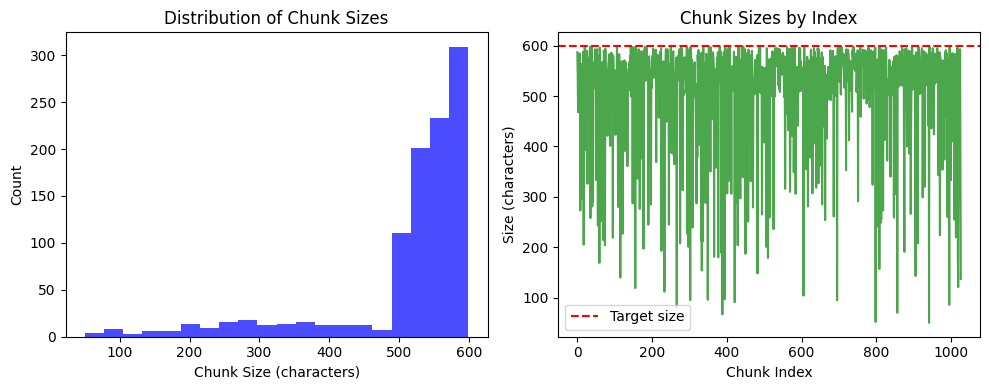


Chunk size statistics:
  Min: 50 chars
  Max: 599 chars
  Mean: 512 chars
  Target: 600 chars


## Vector Store Management

### Creating FAISS Vector Store

Processing 1027 chunks...
FAISS index saved to: ./data/faiss_index
Vector store created successfully


## Building RAG Pipeline

2025-07-30 16:36:43,124 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:36:43,157 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:36:43,157 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:36:43,157 - factories.retriever - INFO - Successfully created hybrid retriever
Created hybrid retriever
2025-07-30 16:36:43,158 - factories.generator - INFO - Created OpenAI generator with model gpt-4o-mini
2025-07-30 16:36:43,158 - factories.generator - INFO - Successfully created openai generator
Created openai generator
Built linear pipeline


Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

### Query: What should I do if my file size exceeds the 4GB limit?

2025-07-30 16:36:43,160 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:36:43,193 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:36:43,194 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:36:43,194 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** The provided context does not contain any information regarding what to do if a file size exceeds the 4GB limit. Therefore, I cannot provide an answer to that question based on the available information.


⏱️ Response time: 1.65s
📄 Retrieved 14 contexts
2025-07-30 16:36:56,783 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  12%|█▎        | 1/8 [00:13<01:35, 13.63s/it]

### Query: How should I sample new data without biasing results?

2025-07-30 16:36:56,795 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:36:56,835 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:36:56,836 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:36:56,836 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** To sample new data without biasing results, consider the following approaches based on the provided context:

- **Use of Covariates**: For experiments involving new users who lack pre-experiment data, leverage covariates like demographics to enhance the analysis. This helps in controlling for potential biases that may arise from the absence of historical data.

- **CUPED Methodology**: If the experiment includes both new and established users, apply the CUPED (Controlled, Unbiased, Pre-Experiment Data) method only to users with pre-experiment data. This allows for more reliable results by reducing variance.

- **Conduct Blind Analyses**: Analyze data without knowing which group is the control or treatment to maintain objectivity and avoid bias in interpreting results.

- **Maintain Healthy Skepticism**: Approach test results critically, especially when outcomes are unexpectedly positive, to avoid human bias and ensure objective analysis.

These strategies can help mitigate biases and improve the reliability of the results in A/B testing scenarios.


⏱️ Response time: 5.16s
📄 Retrieved 13 contexts
2025-07-30 16:37:34,997 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  25%|██▌       | 2/8 [00:51<02:48, 28.09s/it]

### Query: What is Type I error (α), and how does it affect my experiment?

2025-07-30 16:37:35,005 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:37:35,043 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:37:35,043 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:37:35,043 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** Type I error (α), also known as a false positive, occurs when a null hypothesis is incorrectly rejected when it is actually true. This means that the test concludes there is an effect or difference when there is none. 

Key points regarding Type I error (α) and its impact on experiments:

- **Definition**: Type I error is the erroneous rejection of a true null hypothesis. It is sometimes referred to as an error of commission.
- **Significance Level**: The significance level (α) is the probability of committing a Type I error. A common value for α is set at 0.05, indicating a 5% risk of making this error.
- **Impact on Experiments**:
  - If a Type I error occurs, it can lead to false conclusions about the effectiveness of a treatment or intervention, potentially resulting in the adoption of ineffective or harmful practices.
  - The lower the significance level (α), the lower the probability of a Type I error, but this may increase the probability of a Type II error (false negative).

In summary, controlling the Type I error rate is crucial for ensuring the validity of experimental results and avoiding misleading conclusions.


⏱️ Response time: 5.18s
📄 Retrieved 12 contexts
2025-07-30 16:38:08,423 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  38%|███▊      | 3/8 [01:25<02:32, 30.53s/it]

### Query: What effect does my chosen alpha (0.05) have on false positives here?

2025-07-30 16:38:08,430 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:38:08,472 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:38:08,473 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:38:08,474 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** Choosing an alpha level of 0.05 has the following effects on false positives:

- **Probability of False Positives**: An alpha level of 0.05 means there is a 5% chance of committing a type I error, which is a false positive. This indicates that there is a 95% chance that the null hypothesis is correct and that the treatment is no better than the control.
- **Balance with Type II Errors**: Lowering the alpha level can reduce the probability of false positives but increases the probability of type II errors (false negatives). Thus, there is a trade-off between the two types of errors.
- **Common Acceptance**: The alpha level of 0.05 is a commonly accepted standard, representing a balance between the risk of false positives and the need for statistical power in tests.

In summary, setting alpha at 0.05 allows for a controlled risk of false positives while maintaining a reasonable chance of detecting true effects.


⏱️ Response time: 4.84s
📄 Retrieved 12 contexts
2025-07-30 16:38:36,665 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  50%|█████     | 4/8 [01:53<01:58, 29.63s/it]

### Query: What is CUPED and how does it improve my experiment analysis?

2025-07-30 16:38:36,678 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:38:36,721 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:38:36,721 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:38:36,722 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** CUPED, which stands for Controlled-experiment Using Pre-Experiment Data, is a statistical modeling technique that enhances the speed and accuracy of experimentation programs. It was introduced by Microsoft in 2013 and is increasingly recognized in online experimentation.

### How CUPED Improves Experiment Analysis:

- **Variance Reduction**: CUPED incorporates pre-experiment metrics to adjust ongoing experiment estimates, which helps mitigate noise (unwanted variability) in the data. This leads to:
  - Enhanced statistical power and precision of experimental results.
  - Improved ability to detect true treatment effects that may be obscured by randomness.

- **Contextual Understanding**: By analyzing both current and historical data, CUPED provides a richer contextual understanding of user behavior, allowing for more accurate interpretations and decisions based on the data.

- **Efficiency in Experimentation**: 
  - CUPED can significantly reduce the sample sizes needed for experiments, leading to quicker turnarounds and enabling teams to iterate rapidly.
  - This efficiency is particularly beneficial in fast-paced environments where time-to-market is critical.

- **Robust Mechanism for Decision-Making**: By providing reliable conclusions from experiments, CUPED empowers analysts to make confident data-driven decisions.

In summary, CUPED is a powerful tool that leverages historical data to refine experimental analysis, reduce noise, and improve the reliability of conclusions drawn from experiments.


⏱️ Response time: 6.85s
📄 Retrieved 12 contexts
2025-07-30 16:39:16,027 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  62%|██████▎   | 5/8 [02:32<01:39, 33.14s/it]

### Query: How can I validate that CUPED adjustment improved sensitivity in my current dataset?

2025-07-30 16:39:16,034 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:39:16,069 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:39:16,070 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:39:16,072 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** To validate that CUPED adjustment improved sensitivity in your current dataset, you can follow these steps based on the context provided:

- **Compare Results Before and After CUPED**: Analyze the experimental results both with and without the CUPED adjustments. Look for differences in the statistical power and precision of the estimates.

- **Check for Noise Reduction**: Assess whether the CUPED adjustments have effectively reduced the noise in your data. This can be indicated by tighter confidence intervals, which suggest improved sensitivity.

- **Evaluate Detection of Treatment Effects**: Determine if the CUPED adjustments have led to the detection of true treatment effects that were previously obscured by randomness. The context states that "the adjustments made by CUPED often lead to detecting true treatment effects that may otherwise be obscured by randomness."

- **Use Statistical Tests**: Conduct statistical tests to compare the variance of the outcome metrics before and after applying CUPED. A significant reduction in variance would indicate improved sensitivity.

- **Monitor High-Variance Metrics**: Since CUPED is particularly effective on high-variance numeric metrics (e.g., revenue per visitor, average order value), ensure that these metrics show improved sensitivity post-adjustment.

By following these steps, you can validate the effectiveness of CUPED in enhancing the sensitivity of your dataset.


⏱️ Response time: 6.15s
📄 Retrieved 13 contexts
2025-07-30 16:39:49,082 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  75%|███████▌  | 6/8 [03:05<01:06, 33.11s/it]

### Query: If the QQ plot for an outcome metric deviates significantly from the diagonal line, what does this imply about the data distribution?

2025-07-30 16:39:49,091 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:39:49,133 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:39:49,133 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:39:49,134 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** If the Q-Q plot for an outcome metric deviates significantly from the diagonal line (identity line y = x), it implies that the data distribution is not normal. Specifically:

- Points that curve away from the line suggest that the data is likely not normally distributed.
- If the points are above or below the line, it indicates that the distributions differ.

This is important because "if the data is not normal, the test might give misleading results" (Document 1).


⏱️ Response time: 3.36s
📄 Retrieved 12 contexts
2025-07-30 16:40:03,887 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  88%|████████▊ | 7/8 [03:20<00:27, 27.12s/it]

### Query: What if Q-Q plots deviate from diagonal in my revenue data?

2025-07-30 16:40:03,895 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:40:03,934 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:40:03,935 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:40:03,935 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** If Q–Q plots deviate from the diagonal line (y = x) in your revenue data, it suggests the following:

- **Non-Normal Distribution**: The points in the Q–Q plot will not lie on the line y = x if the distributions are not normally distributed. This indicates that the data may not follow a standard normal distribution.
- **Dispersion Differences**: 
  - If the points lie below the line, it suggests that the distribution plotted on the horizontal axis is more dispersed than the distribution plotted on the vertical axis.
  - Conversely, if the points lie above the line, it indicates that the distribution plotted on the vertical axis is more dispersed than the distribution plotted on the horizontal axis.
- **Skewness or Heavy Tails**: The Q–Q plot may also appear arced or S-shaped, indicating that one of the distributions is more skewed than the other or that one has heavier tails.

These observations can help in understanding the differences in the underlying distributions of your revenue data.


⏱️ Response time: 5.82s
📄 Retrieved 13 contexts
2025-07-30 16:40:30,300 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating: 100%|██████████| 8/8 [03:47<00:00, 28.39s/it]


Configuration 8/16
Variant: {'loader': 'pdf', 'chunker': 'semantic_600', 'embedding': 'openai_text-embedding-3-small', 'storage': 'faiss', 'retrieval': 'hybrid_k7', 'generation': 'openai_gpt-4o-mini'}
2025-07-30 16:40:30,319 - system.rag_system - INFO - Initializing RAG system components


## Initializing RAG System Components

2025-07-30 16:40:30,321 - system.rag_system - INFO - Document processor initialized
✓ Document processor initialized
Initialized embeddings with model: text-embedding-3-small
2025-07-30 16:40:30,338 - system.rag_system - INFO - Vector store manager initialized
✓ Vector store manager initialized
2025-07-30 16:40:30,338 - system.rag_system - INFO - Component factories initialized
✓ Component factories initialized
2025-07-30 16:40:30,343 - system.rag_system - INFO - Pipeline builder initialized
✓ Pipeline builder initialized
2025-07-30 16:40:30,367 - system.rag_system - INFO - Evaluation systems initialized
✓ Evaluation systems initialized
2025-07-30 16:40:30,368 - document_processing.processor - INFO - Loading PDFs from directory: documents


Ignoring wrong pointing object 7 0 (offset 0)
Ignoring wrong pointing object 9 0 (offset 0)
Ignoring wrong pointing object 54 0 (offset 0)
Ignoring wrong pointing object 236 0 (offset 0)
Ignoring wrong pointing object 670 0 (offset 0)
Ignoring wrong pointing object 1329 0 (offset 0)
Ignoring wrong pointing object 1330 0 (offset 0)


2025-07-30 16:40:36,998 - document_processing.processor - INFO - Loaded 224 document pages


### Loading Summary

Loaded 224 document pages


#### First Document Preview:

Source: documents/kb.pdf
Page: 0
Content preview: RAG KNOWLEDGE BASE 
 
Explaining the Streamlit platform 
 
1. Experiment design tab: calculating sample sizes before running an 
experiment 
Purpose: Before launching an A/B test, we want to calculate...
2025-07-30 16:40:37,000 - document_processing.processor - WARNING - Semantic chunking not yet implemented, falling back to recursive
2025-07-30 16:40:37,020 - document_processing.processor - INFO - Created 1027 chunks with recursive strategy


### Chunking Summary

Created 1027 chunks from 224 documents
Average chunk size: 512 characters


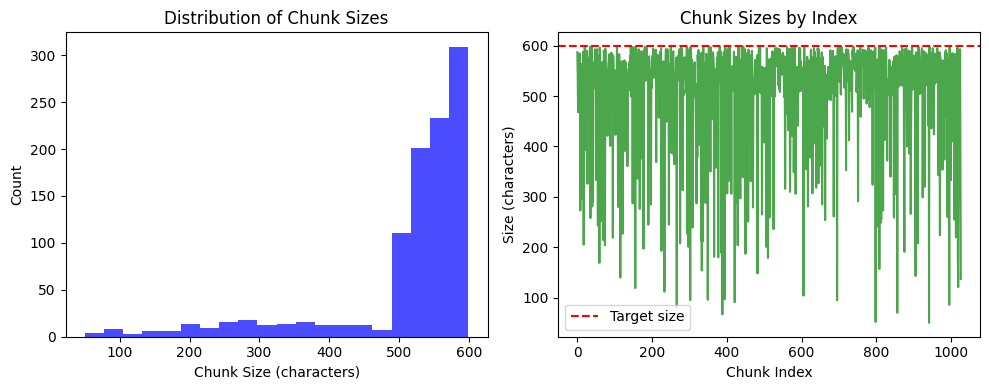


Chunk size statistics:
  Min: 50 chars
  Max: 599 chars
  Mean: 512 chars
  Target: 600 chars


## Vector Store Management

### Creating FAISS Vector Store

Processing 1027 chunks...
FAISS index saved to: ./data/faiss_index
Vector store created successfully


## Building RAG Pipeline

2025-07-30 16:40:41,539 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:40:41,575 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:40:41,575 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:40:41,576 - factories.retriever - INFO - Successfully created hybrid retriever
Created hybrid retriever
2025-07-30 16:40:41,576 - factories.generator - INFO - Created OpenAI generator with model gpt-4o-mini
2025-07-30 16:40:41,577 - factories.generator - INFO - Successfully created openai generator
Created openai generator
Built linear pipeline


Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

### Query: What should I do if my file size exceeds the 4GB limit?

2025-07-30 16:40:41,579 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:40:41,612 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:40:41,613 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:40:41,613 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** The provided context does not contain any information regarding what to do if a file size exceeds the 4GB limit. Therefore, I cannot provide an answer to that question based on the available information.


⏱️ Response time: 2.23s
📄 Retrieved 14 contexts
2025-07-30 16:40:51,159 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  12%|█▎        | 1/8 [00:09<01:07,  9.59s/it]

### Query: How should I sample new data without biasing results?

2025-07-30 16:40:51,168 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:40:51,205 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:40:51,205 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:40:51,205 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** To sample new data without biasing results, consider the following guidelines based on the provided context:

- **Use of Covariates**: Since new users won’t have pre-experiment data, leverage covariates like demographics if possible. This helps in analyzing the data without bias.
- **CUPED Methodology**: If the experiment includes both new and established users, apply the CUPED method only to users with pre-experiment data. This allows for better variance reduction and more reliable results.
- **Blind Analyses**: Conduct analyses without knowing which group is the control or treatment to maintain objectivity and avoid bias.
- **Maintain Skepticism**: Approach test results critically, especially when outcomes are unexpectedly positive, to avoid human bias.

These practices help ensure that the sampling and analysis of new data are conducted in a way that minimizes bias and enhances the reliability of the results.


⏱️ Response time: 4.89s
📄 Retrieved 13 contexts
2025-07-30 16:41:19,122 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  25%|██▌       | 2/8 [00:37<02:02, 20.40s/it]

### Query: What is Type I error (α), and how does it affect my experiment?

2025-07-30 16:41:19,145 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:41:19,189 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:41:19,190 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:41:19,190 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** Type I error (α), also known as a false positive, occurs when a null hypothesis is incorrectly rejected when it is actually true. This means that the test concludes there is an effect or difference when there is none. 

Key points regarding Type I error and its impact on experiments:

- **Definition**: Type I error is the erroneous rejection of a true null hypothesis. It is sometimes referred to as an error of commission.
- **Significance Level**: The probability of committing a Type I error is denoted by the Greek letter α (alpha), which is often set at a common value of 0.05. This implies a 5% chance of incorrectly rejecting the true null hypothesis.
- **Impact on Experiments**:
  - A Type I error can lead to false conclusions, suggesting that a treatment or intervention has an effect when it does not.
  - It can result in wasted resources, as further actions may be taken based on incorrect findings.
  - The closer the significance level (α) is to 0, the lower the probability of a Type I error, but this may increase the probability of a Type II error (false negative).

In summary, controlling the Type I error rate is crucial for ensuring the validity of experimental conclusions.


⏱️ Response time: 6.31s
📄 Retrieved 12 contexts
2025-07-30 16:41:53,782 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  38%|███▊      | 3/8 [01:12<02:14, 26.91s/it]

### Query: What effect does my chosen alpha (0.05) have on false positives here?

2025-07-30 16:41:53,793 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:41:53,833 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:41:53,834 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:41:53,834 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** Choosing an alpha level of 0.05 has the following effects on false positives:

- **Probability of False Positives**: An alpha level of 0.05 means there is a 5% chance of committing a type I error, which is a false positive. This indicates that there is a 95% chance that the null hypothesis is correct and that the treatment is no better than the control.
  
- **Balance with Type II Error**: Lowering the alpha level would decrease the probability of false positives but would increase the probability of type II errors (false negatives). The context states, "The closer to 0, the lower the probability of a type I error/false positive, but the higher the probability of a type II error/false negative."

In summary, setting alpha at 0.05 allows for a manageable risk of false positives while maintaining a balance with the risk of false negatives.


⏱️ Response time: 4.66s
📄 Retrieved 12 contexts
2025-07-30 16:42:20,024 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  50%|█████     | 4/8 [01:38<01:46, 26.64s/it]

### Query: What is CUPED and how does it improve my experiment analysis?

2025-07-30 16:42:20,031 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:42:20,073 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:42:20,074 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:42:20,074 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** CUPED, which stands for Controlled-experiment Using Pre-Experiment Data, is a statistical modeling technique that enhances the speed and accuracy of experimentation programs. Here’s how it improves experiment analysis:

- **Variance Reduction**: CUPED incorporates pre-experiment metrics to adjust ongoing experiment estimates, thereby reducing noise (unwanted variability) in the data. This leads to:
  - Enhanced statistical power and precision of experimental results.
  - Improved ability to detect true treatment effects that might be obscured by randomness.

- **Contextual Understanding**: By analyzing both current and historical data, CUPED provides a richer contextual understanding of user behavior, which helps in making more informed decisions.

- **Efficiency in Experimentation**: 
  - CUPED can significantly reduce the sample sizes needed for experiments, allowing for quicker turnarounds and faster iterations.
  - This efficiency is particularly beneficial in fast-paced environments where time-to-market is critical.

- **Robust Mechanism for Decision-Making**: It empowers analysts by providing a structured approach to improving statistical estimates, leading to more reliable conclusions from experimental data.

In summary, CUPED is a powerful tool that enhances the reliability and efficiency of experiment analysis by leveraging historical data to reduce variance and improve the accuracy of results.


⏱️ Response time: 8.76s
📄 Retrieved 12 contexts
2025-07-30 16:42:55,838 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  62%|██████▎   | 5/8 [02:14<01:29, 29.95s/it]

### Query: How can I validate that CUPED adjustment improved sensitivity in my current dataset?

2025-07-30 16:42:55,853 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:42:55,908 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:42:55,908 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:42:55,909 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** To validate that CUPED adjustment improved sensitivity in your current dataset, you can follow these steps based on the context provided:

- **Compare Pre- and Post-CUPED Results**: Analyze the experimental results before and after applying CUPED to see if there is an increase in the ability to detect true treatment effects.
  
- **Examine Variance Reduction**: Check if the variance of your outcome metric has decreased after applying CUPED. This reduction in variance should lead to tighter confidence intervals, making it easier to identify significant effects.

- **Use Statistical Tests**: Conduct statistical tests to compare the sensitivity of your results before and after applying CUPED. Look for improvements in metrics such as statistical power.

- **Assess Correlation**: Ensure that the covariates used in CUPED are correlated with the outcome metric. This correlation is crucial for CUPED's effectiveness in reducing noise and improving sensitivity.

- **Monitor High-Variance Metrics**: Focus on high-variance numeric metrics (e.g., revenue per visitor, average order value) where CUPED is known to deliver the most impact.

By following these steps, you can effectively validate the improvements in sensitivity due to CUPED adjustments in your dataset.


⏱️ Response time: 8.56s
📄 Retrieved 13 contexts
2025-07-30 16:43:37,488 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  75%|███████▌  | 6/8 [02:55<01:07, 33.93s/it]

### Query: If the QQ plot for an outcome metric deviates significantly from the diagonal line, what does this imply about the data distribution?

2025-07-30 16:43:37,499 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:43:37,546 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:43:37,547 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:43:37,547 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** If the Q-Q plot for an outcome metric deviates significantly from the diagonal line (identity line y = x), it implies that the data distribution is not normally distributed. Specifically:

- Points that curve away from the line suggest that the data is likely not normally distributed.
- If the points are above or below the line, it indicates that the distributions differ.

This is important because "if the data is not normal, the test might give misleading results" (Document 1).


⏱️ Response time: 2.70s
📄 Retrieved 12 contexts
2025-07-30 16:43:52,444 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  88%|████████▊ | 7/8 [03:10<00:27, 27.73s/it]

### Query: What if Q-Q plots deviate from diagonal in my revenue data?

2025-07-30 16:43:52,457 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:43:52,502 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:43:52,502 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:43:52,502 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** If Q–Q plots deviate from the diagonal line (y = x) in your revenue data, it suggests the following:

- **Non-Normal Distribution**: The points in the Q–Q plot will not lie on the line y = x if the distributions are not normally distributed. This indicates that the data may not follow a standard normal distribution.
- **Dispersion**: 
  - If the points are below the line, it suggests that the distribution plotted on the horizontal axis is more dispersed than the distribution plotted on the vertical axis.
  - Conversely, if the points are above the line, it indicates that the distribution plotted on the vertical axis is more dispersed than the distribution plotted on the horizontal axis.
- **Skewness or Heavy Tails**: An S-shaped or arced pattern in the Q–Q plot may indicate that one of the distributions is more skewed than the other or that one has heavier tails.

In summary, deviations from the diagonal line in a Q–Q plot can reveal important characteristics about the distributions being compared, such as differences in dispersion, skewness, or overall fit to a normal distribution.


⏱️ Response time: 5.71s
📄 Retrieved 13 contexts
2025-07-30 16:44:24,167 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating: 100%|██████████| 8/8 [03:42<00:00, 27.83s/it]


Configuration 9/16
Variant: {'loader': 'pdf', 'chunker': 'semantic_600', 'embedding': 'openai_text-embedding-3-small', 'storage': 'faiss', 'retrieval': 'hybrid_k7', 'generation': 'openai_gpt-4o-mini'}
2025-07-30 16:44:24,187 - system.rag_system - INFO - Initializing RAG system components


## Initializing RAG System Components

2025-07-30 16:44:24,189 - system.rag_system - INFO - Document processor initialized
✓ Document processor initialized
Initialized embeddings with model: text-embedding-3-small
2025-07-30 16:44:24,208 - system.rag_system - INFO - Vector store manager initialized
✓ Vector store manager initialized
2025-07-30 16:44:24,208 - system.rag_system - INFO - Component factories initialized
✓ Component factories initialized
2025-07-30 16:44:24,209 - system.rag_system - INFO - Pipeline builder initialized
✓ Pipeline builder initialized
2025-07-30 16:44:24,224 - system.rag_system - INFO - Evaluation systems initialized
✓ Evaluation systems initialized
2025-07-30 16:44:24,225 - document_processing.processor - INFO - Loading PDFs from directory: documents


Ignoring wrong pointing object 7 0 (offset 0)
Ignoring wrong pointing object 9 0 (offset 0)
Ignoring wrong pointing object 54 0 (offset 0)
Ignoring wrong pointing object 236 0 (offset 0)
Ignoring wrong pointing object 670 0 (offset 0)
Ignoring wrong pointing object 1329 0 (offset 0)
Ignoring wrong pointing object 1330 0 (offset 0)


2025-07-30 16:44:30,904 - document_processing.processor - INFO - Loaded 224 document pages


### Loading Summary

Loaded 224 document pages


#### First Document Preview:

Source: documents/kb.pdf
Page: 0
Content preview: RAG KNOWLEDGE BASE 
 
Explaining the Streamlit platform 
 
1. Experiment design tab: calculating sample sizes before running an 
experiment 
Purpose: Before launching an A/B test, we want to calculate...
2025-07-30 16:44:30,906 - document_processing.processor - WARNING - Semantic chunking not yet implemented, falling back to recursive
2025-07-30 16:44:30,924 - document_processing.processor - INFO - Created 1027 chunks with recursive strategy


### Chunking Summary

Created 1027 chunks from 224 documents
Average chunk size: 512 characters


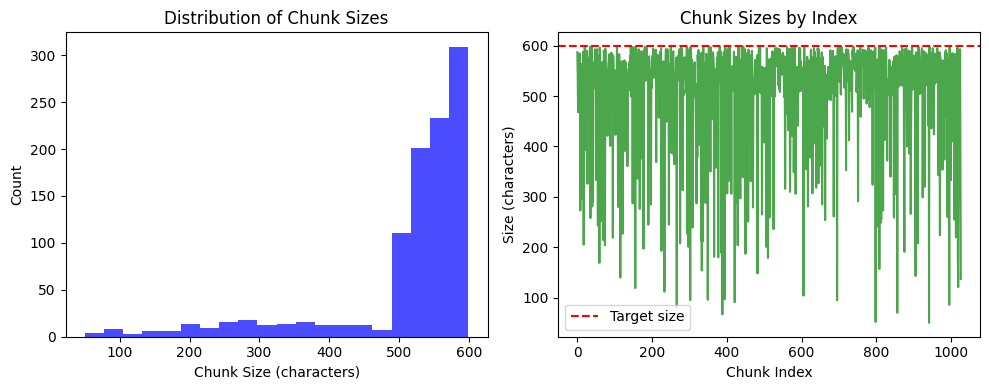


Chunk size statistics:
  Min: 50 chars
  Max: 599 chars
  Mean: 512 chars
  Target: 600 chars


## Vector Store Management

### Creating FAISS Vector Store

Processing 1027 chunks...
FAISS index saved to: ./data/faiss_index
Vector store created successfully


## Building RAG Pipeline

2025-07-30 16:44:35,692 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:44:35,730 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:44:35,731 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:44:35,731 - factories.retriever - INFO - Successfully created hybrid retriever
Created hybrid retriever
2025-07-30 16:44:35,733 - factories.generator - INFO - Created OpenAI generator with model gpt-4o-mini
2025-07-30 16:44:35,733 - factories.generator - INFO - Successfully created openai generator
Created openai generator
Built linear pipeline


Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

### Query: What should I do if my file size exceeds the 4GB limit?

2025-07-30 16:44:35,737 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:44:35,777 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:44:35,778 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:44:35,778 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** The provided context does not contain any information regarding what to do if a file size exceeds the 4GB limit. Therefore, I cannot provide an answer to that question based on the available information.


⏱️ Response time: 2.74s
📄 Retrieved 14 contexts
2025-07-30 16:44:47,999 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  12%|█▎        | 1/8 [00:12<01:25, 12.27s/it]

### Query: How should I sample new data without biasing results?

2025-07-30 16:44:48,009 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:44:48,047 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:44:48,048 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:44:48,048 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** To sample new data without biasing results, consider the following guidelines based on the provided context:

- **Use of Covariates**: Since new users won’t have pre-experiment data, leverage covariates like demographics if possible. This helps in analyzing the data without introducing bias.
- **CUPED Method**: If your experiment includes both new and established users, apply the CUPED method only to users with pre-experiment data. This allows for better variance reduction and more reliable results.
- **Blind Analyses**: Conduct analyses without knowing which group is the control or treatment to maintain objectivity and avoid bias.
- **Maintain Skepticism**: Approach test results critically, especially if outcomes are unexpectedly positive, to avoid human bias.

These practices help ensure that the sampling and analysis of new data are conducted in a way that minimizes bias and enhances the reliability of the results.


⏱️ Response time: 5.75s
📄 Retrieved 13 contexts
2025-07-30 16:45:16,498 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  25%|██▌       | 2/8 [00:40<02:10, 21.82s/it]

### Query: What is Type I error (α), and how does it affect my experiment?

2025-07-30 16:45:16,512 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:45:16,553 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:45:16,554 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:45:16,554 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** Type I error (α), also known as a false positive, occurs when a null hypothesis is incorrectly rejected when it is actually true. This means that the test concludes there is an effect or difference when, in reality, there is none. 

Key points about Type I error (α) and its impact on experiments:

- **Definition**: Type I error is the erroneous rejection of a true null hypothesis. It is sometimes referred to as an error of commission.
- **Significance Level**: The significance level (α) is the probability of committing a Type I error. A common value for α is set at 0.05, indicating a 5% risk of incorrectly rejecting the null hypothesis.
- **Impact on Experiments**:
  - If a Type I error occurs, it can lead to false conclusions about the effectiveness of a treatment or intervention, potentially resulting in misguided decisions based on incorrect data.
  - The closer the significance level is to 0, the lower the probability of a Type I error, but this may increase the probability of a Type II error (false negative).

In summary, Type I error can significantly affect the validity of experimental results by leading to incorrect conclusions about the presence of an effect or difference when none exists.


⏱️ Response time: 6.85s
📄 Retrieved 12 contexts
2025-07-30 16:45:44,580 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  38%|███▊      | 3/8 [01:08<02:03, 24.68s/it]

### Query: What effect does my chosen alpha (0.05) have on false positives here?

2025-07-30 16:45:44,590 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:45:44,657 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:45:44,658 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:45:44,659 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** Choosing an alpha level of 0.05 has the following effects on false positives:

- **Probability of False Positives**: An alpha level of 0.05 means there is a 5% chance of committing a type I error, which is a false positive. This indicates that if the null hypothesis is true, there is a 5% probability of incorrectly rejecting it.
- **Balance with Type II Errors**: Lowering the alpha level would decrease the probability of false positives but would increase the probability of type II errors (false negatives). The context states, "The closer to 0, the lower the probability of a type I error/false positive, but the higher the probability of a type II error/false negative."
- **Common Acceptance**: The alpha level of 0.05 is commonly accepted as a "happy middle ground" for balancing the risks of false positives and false negatives.

In summary, setting alpha at 0.05 allows for a controlled risk of false positives while maintaining a reasonable chance of detecting true effects.


⏱️ Response time: 9.40s
📄 Retrieved 12 contexts
2025-07-30 16:46:12,454 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  50%|█████     | 4/8 [01:36<01:43, 25.94s/it]

### Query: What is CUPED and how does it improve my experiment analysis?

2025-07-30 16:46:12,466 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:46:12,506 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:46:12,507 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:46:12,507 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** CUPED, which stands for Controlled-experiment Using Pre-Experiment Data, is a statistical modeling technique developed by Microsoft in 2013. It is increasingly used in online experimentation to enhance the speed and accuracy of experimental programs. Here’s how CUPED improves experiment analysis:

- **Variance Reduction**: CUPED incorporates pre-experiment metrics to adjust ongoing experiment estimates, which helps mitigate noise (unwanted variability) in the data. This leads to:
  - Enhanced statistical power and precision of experimental results.
  - Improved ability to detect true treatment effects that might be obscured by randomness.

- **Contextual Understanding**: By analyzing both current and historical data, CUPED provides a richer contextual understanding of user behavior, allowing for more accurate interpretations and decisions based on the data.

- **Sample Size Efficiency**: CUPED can significantly reduce the sample sizes needed for experiments, leading to quicker turnarounds and enabling teams to iterate rapidly, which is crucial in fast-paced environments.

- **Robust Mechanism for Decision-Making**: It empowers analysts to draw reliable conclusions from experiments, thereby improving the overall efficiency of data-driven decision-making processes.

In summary, CUPED is a powerful tool for improving the reliability and efficiency of experiment analysis by leveraging historical data to reduce variance and enhance the clarity of findings.


⏱️ Response time: 6.22s
📄 Retrieved 12 contexts
2025-07-30 16:46:46,191 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  62%|██████▎   | 5/8 [02:10<01:26, 28.75s/it]

### Query: How can I validate that CUPED adjustment improved sensitivity in my current dataset?

2025-07-30 16:46:46,204 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:46:46,244 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:46:46,245 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:46:46,245 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** To validate that CUPED adjustment improved sensitivity in your current dataset, you can follow these steps based on the context provided:

- **Compare Pre- and Post-CUPED Results**: Analyze the outcomes before and after applying CUPED to see if there is a noticeable increase in the sensitivity of your results. This can be done by checking if smaller treatment effects can now be detected.

- **Examine Confidence Intervals**: Look for tightened confidence intervals in your results after applying CUPED. The context states, "This tightening of confidence intervals is what makes CUPED so effective."

- **Assess Variance Reduction**: Evaluate the variance in your outcome metrics before and after applying CUPED. The technique is designed to "reduce variance in your outcome metric by using pre-experiment information that’s correlated with the outcome."

- **Statistical Testing**: Conduct statistical tests to determine if the changes in sensitivity are statistically significant. This can involve comparing the power of tests conducted with and without CUPED adjustments.

- **Check Correlation**: Ensure that the metrics used in CUPED are correlated with their past values, as CUPED's effectiveness relies on this correlation. The context mentions that CUPED's ability to adjust values is based on "how correlated a metric is with its past value."

By following these steps, you can effectively validate the improvement in sensitivity due to CUPED adjustments in your dataset.


⏱️ Response time: 9.75s
📄 Retrieved 13 contexts
2025-07-30 16:47:26,966 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  75%|███████▌  | 6/8 [02:51<01:05, 32.84s/it]

### Query: If the QQ plot for an outcome metric deviates significantly from the diagonal line, what does this imply about the data distribution?

2025-07-30 16:47:26,978 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:47:27,017 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:47:27,018 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:47:27,018 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** If the Q-Q plot for an outcome metric deviates significantly from the diagonal line (identity line), it implies that the data distribution is likely not normally distributed. Specifically:

- Points that curve away from the line suggest that the data does not follow a normal distribution.
- If the points are above or below the line, it indicates that the distributions being compared differ.

As stated in the context, "If the points curve away from the line (especially at the tails) then the data is likely not normally distributed."


⏱️ Response time: 3.46s
📄 Retrieved 12 contexts
2025-07-30 16:47:41,979 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  88%|████████▊ | 7/8 [03:06<00:27, 27.01s/it]

### Query: What if Q-Q plots deviate from diagonal in my revenue data?

2025-07-30 16:47:41,992 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:47:42,030 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:47:42,031 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:47:42,031 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** If Q–Q plots deviate from the diagonal line (y = x) in your revenue data, it suggests the following:

- **Non-Normal Distribution**: The points in the Q–Q plot will not lie on the line y = x if the distributions being compared are not similar or if the data does not follow a normal distribution.
- **Dispersion Differences**: 
  - If the points are below the line, it indicates that the distribution plotted on the horizontal axis is more dispersed than the distribution on the vertical axis.
  - Conversely, if the points are above the line, it suggests that the distribution on the vertical axis is more dispersed than the one on the horizontal axis.
- **Skewness or Heavy Tails**: An S-shaped or arced pattern in the Q–Q plot may indicate that one of the distributions is more skewed or has heavier tails than the other.

These observations can help assess the fit of your revenue data to a theoretical distribution or compare it with another dataset.


⏱️ Response time: 5.62s
📄 Retrieved 13 contexts
2025-07-30 16:48:10,634 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating: 100%|██████████| 8/8 [03:34<00:00, 26.86s/it]


Configuration 10/16
Variant: {'loader': 'pdf', 'chunker': 'semantic_600', 'embedding': 'openai_text-embedding-3-small', 'storage': 'faiss', 'retrieval': 'hybrid_k7', 'generation': 'openai_gpt-4o-mini'}
2025-07-30 16:48:10,660 - system.rag_system - INFO - Initializing RAG system components


## Initializing RAG System Components

2025-07-30 16:48:10,662 - system.rag_system - INFO - Document processor initialized
✓ Document processor initialized
Initialized embeddings with model: text-embedding-3-small
2025-07-30 16:48:10,692 - system.rag_system - INFO - Vector store manager initialized
✓ Vector store manager initialized
2025-07-30 16:48:10,692 - system.rag_system - INFO - Component factories initialized
✓ Component factories initialized
2025-07-30 16:48:10,693 - system.rag_system - INFO - Pipeline builder initialized
✓ Pipeline builder initialized
2025-07-30 16:48:10,714 - system.rag_system - INFO - Evaluation systems initialized
✓ Evaluation systems initialized
2025-07-30 16:48:10,715 - document_processing.processor - INFO - Loading PDFs from directory: documents


Ignoring wrong pointing object 7 0 (offset 0)
Ignoring wrong pointing object 9 0 (offset 0)
Ignoring wrong pointing object 54 0 (offset 0)
Ignoring wrong pointing object 236 0 (offset 0)
Ignoring wrong pointing object 670 0 (offset 0)
Ignoring wrong pointing object 1329 0 (offset 0)
Ignoring wrong pointing object 1330 0 (offset 0)


2025-07-30 16:48:17,183 - document_processing.processor - INFO - Loaded 224 document pages


### Loading Summary

Loaded 224 document pages


#### First Document Preview:

Source: documents/kb.pdf
Page: 0
Content preview: RAG KNOWLEDGE BASE 
 
Explaining the Streamlit platform 
 
1. Experiment design tab: calculating sample sizes before running an 
experiment 
Purpose: Before launching an A/B test, we want to calculate...
2025-07-30 16:48:17,185 - document_processing.processor - WARNING - Semantic chunking not yet implemented, falling back to recursive
2025-07-30 16:48:17,203 - document_processing.processor - INFO - Created 1027 chunks with recursive strategy


### Chunking Summary

Created 1027 chunks from 224 documents
Average chunk size: 512 characters


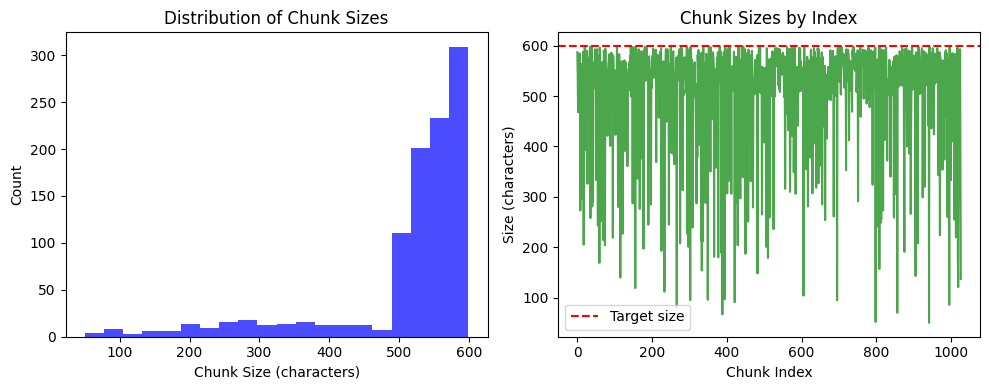


Chunk size statistics:
  Min: 50 chars
  Max: 599 chars
  Mean: 512 chars
  Target: 600 chars


## Vector Store Management

### Creating FAISS Vector Store

Processing 1027 chunks...
FAISS index saved to: ./data/faiss_index
Vector store created successfully


## Building RAG Pipeline

2025-07-30 16:48:23,025 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:48:23,081 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:48:23,082 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:48:23,082 - factories.retriever - INFO - Successfully created hybrid retriever
Created hybrid retriever
2025-07-30 16:48:23,083 - factories.generator - INFO - Created OpenAI generator with model gpt-4o-mini
2025-07-30 16:48:23,083 - factories.generator - INFO - Successfully created openai generator
Created openai generator
Built linear pipeline


Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

### Query: What should I do if my file size exceeds the 4GB limit?

2025-07-30 16:48:23,085 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:48:23,118 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:48:23,118 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:48:23,118 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** The provided context does not contain any information regarding what to do if a file size exceeds the 4GB limit. Therefore, I cannot provide an answer to that question based on the available information.


⏱️ Response time: 1.77s
📄 Retrieved 14 contexts
2025-07-30 16:48:32,254 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  12%|█▎        | 1/8 [00:09<01:04,  9.18s/it]

### Query: How should I sample new data without biasing results?

2025-07-30 16:48:32,266 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:48:32,327 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:48:32,327 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:48:32,328 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** To sample new data without biasing results, consider the following guidelines based on the provided context:

- **Use of Covariates**: Since new users lack pre-experiment data, leverage covariates like demographics when possible. This helps in controlling for potential biases.
  
- **CUPED Methodology**: If your experiment includes both new and established users, apply the CUPED method only to users with pre-experiment data. This approach can help reduce variance and improve the reliability of results.

- **Blind Analyses**: Conduct analyses without knowing which group is the control or treatment. This helps maintain objectivity and reduces the risk of bias in interpreting results.

- **Maintain Skepticism**: Always approach test results critically, especially if outcomes are unexpectedly positive. This mindset helps avoid human bias and ensures a more objective analysis.

These practices can help ensure that the sampling of new data does not introduce bias into the results.


⏱️ Response time: 5.02s
📄 Retrieved 13 contexts
2025-07-30 16:49:00,805 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  25%|██▌       | 2/8 [00:37<02:03, 20.57s/it]

### Query: What is Type I error (α), and how does it affect my experiment?

2025-07-30 16:49:00,813 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:49:00,995 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:49:00,996 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:49:00,996 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** Type I error (α), also known as a false positive, occurs when a null hypothesis is incorrectly rejected when it is actually true. This means that the test suggests there is an effect or difference when there is none. 

Key points about Type I error (α) and its impact on experiments:

- **Definition**: Type I error is the erroneous rejection of a true null hypothesis. It is sometimes referred to as an error of commission.
- **Probability**: The significance level, denoted by α, represents the probability of committing a Type I error. A common value for α is set at 0.05, indicating a 5% chance of incorrectly rejecting the null hypothesis.
- **Impact on Experiments**:
  - **False Conclusions**: A Type I error can lead to false conclusions about the effectiveness of a treatment or intervention, suggesting that it works when it does not.
  - **Significance Level**: The significance level is designed to control the frequency of Type I errors, balancing the risk of false positives against the risk of Type II errors (false negatives).
  - **Trade-off**: Lowering α reduces the likelihood of Type I errors but may increase the likelihood of Type II errors, creating a trade-off in experimental design.

In summary, Type I error is a critical consideration in hypothesis testing, as it can lead to misleading results and conclusions in experiments.


⏱️ Response time: 5.30s
📄 Retrieved 12 contexts
2025-07-30 16:49:32,728 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  38%|███▊      | 3/8 [01:09<02:08, 25.76s/it]

### Query: What effect does my chosen alpha (0.05) have on false positives here?

2025-07-30 16:49:32,740 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:49:32,779 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:49:32,780 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:49:32,780 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** Choosing an alpha level of 0.05 has the following effects on false positives:

- **Probability of False Positives**: An alpha level of 0.05 means there is a 5% chance of committing a type I error, which is a false positive. This indicates that there is a 95% chance that the null hypothesis is correct and that the treatment is no better than the control.
- **Balance with Type II Error**: Lowering the alpha level can reduce the probability of false positives but may increase the probability of type II errors (false negatives). The context states, "The closer to 0, the lower the probability of a type I error/false positive, but the higher the probability of a type II error/false negative."

In summary, an alpha of 0.05 allows for a controlled risk of false positives while balancing the risk of false negatives.


⏱️ Response time: 5.36s
📄 Retrieved 12 contexts
2025-07-30 16:49:57,737 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  50%|█████     | 4/8 [01:34<01:41, 25.46s/it]

### Query: What is CUPED and how does it improve my experiment analysis?

2025-07-30 16:49:57,755 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:49:57,791 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:49:57,792 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:49:57,792 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** CUPED, which stands for Controlled-experiment Using Pre-Experiment Data, is a statistical modeling technique that enhances the speed and accuracy of experimentation programs. It was coined by Microsoft in 2013 and is increasingly recognized in online experimentation.

### How CUPED Improves Experiment Analysis:

- **Variance Reduction**: CUPED incorporates pre-experiment metrics to adjust ongoing experiment estimates, reducing unwanted variability (noise) in the data. This leads to:
  - Enhanced statistical power and precision of experimental results.
  - Improved ability to detect true treatment effects that may be obscured by randomness.

- **Contextual Understanding**: By analyzing both current and historical data, CUPED provides a richer contextual understanding of user behavior, which aids in making more informed decisions.

- **Smaller Sample Sizes**: CUPED can significantly reduce the sample sizes needed for experiments, allowing for quicker turnarounds and enabling teams to iterate rapidly.

- **Robust Mechanism for Decision-Making**: It empowers analysts with a structured approach to improve statistical estimates, leading to more reliable conclusions from experimental data.

- **Adjustment of Metrics**: The CUPED algorithm uses linear regression to model relationships between outcome variables and covariates, adjusting treated and control group metrics based on pre-experiment data.

In summary, CUPED is a powerful tool for improving the reliability and efficiency of experiment analysis by leveraging historical data to reduce noise and enhance the clarity of findings.


⏱️ Response time: 7.66s
📄 Retrieved 12 contexts
2025-07-30 16:50:34,830 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  62%|██████▎   | 5/8 [02:11<01:28, 29.66s/it]

### Query: How can I validate that CUPED adjustment improved sensitivity in my current dataset?

2025-07-30 16:50:34,843 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:50:34,890 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:50:34,891 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:50:34,892 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** To validate that CUPED adjustment improved sensitivity in your current dataset, you can follow these steps based on the context provided:

- **Compare Pre- and Post-CUPED Results**: Analyze the outcomes before and after applying CUPED to see if there is a noticeable improvement in the sensitivity of your metrics.
  
- **Check for Reduced Variance**: Since CUPED is designed to reduce variance in your outcome metric, you should look for a decrease in the variability of your results after applying CUPED. This can be assessed through statistical measures such as confidence intervals.

- **Evaluate Statistical Power**: Assess whether the statistical power of your tests has increased. CUPED enhances statistical power by mitigating noise, which should lead to a higher likelihood of detecting true treatment effects.

- **Use Historical Data Correlation**: Ensure that the adjustments made by CUPED are based on the correlation between past and current metrics. This correlation is crucial for the effectiveness of CUPED, particularly in high-variance metrics like revenue.

- **Conduct Statistical Tests**: Perform statistical tests to compare the significance of results before and after applying CUPED. If the results post-CUPED show greater significance, it indicates improved sensitivity.

By following these steps, you can effectively validate the impact of CUPED adjustments on the sensitivity of your dataset.


⏱️ Response time: 7.05s
📄 Retrieved 13 contexts
2025-07-30 16:51:08,491 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  75%|███████▌  | 6/8 [02:45<01:02, 31.02s/it]

### Query: If the QQ plot for an outcome metric deviates significantly from the diagonal line, what does this imply about the data distribution?

2025-07-30 16:51:08,503 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:51:08,539 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:51:08,539 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:51:08,540 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** If the Q-Q plot for an outcome metric deviates significantly from the diagonal line (identity line), it implies that the data distribution is likely not normally distributed. Specifically:

- Points that curve away from the line suggest that the data does not follow a normal distribution.
- If the points are above or below the line, it indicates that the distributions being compared differ.

As stated in the context, "If the points curve away from the line (especially at the tails) then the data is likely not normally distributed."


⏱️ Response time: 3.06s
📄 Retrieved 12 contexts
2025-07-30 16:51:22,751 - evaluation.orchestrator - ERROR - CoFE-RAG evaluation failed: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/Users/ihebbz/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/share/nltk_data'
    - '/Users/ihebbz/Documents/LSE/Courses/Capstone /Group Repos/RAG Pipeline/rag-pipeline/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_dat

Evaluating:  88%|████████▊ | 7/8 [02:59<00:25, 25.54s/it]

### Query: What if Q-Q plots deviate from diagonal in my revenue data?

2025-07-30 16:51:22,761 - factories.retriever - INFO - Created vector retriever with similarity search
2025-07-30 16:51:22,798 - factories.retriever - INFO - Created BM25 retriever with k=7
2025-07-30 16:51:22,799 - factories.retriever - INFO - Created hybrid retriever with weights [0.7, 0.3]
2025-07-30 16:51:22,799 - factories.retriever - INFO - Successfully created hybrid retriever


**Answer:** If Q–Q plots deviate from the diagonal line (y = x) in your revenue data, it suggests the following:

- **Non-Normal Distribution**: The points in the Q–Q plot will not lie on the line y = x if the distributions are not normally distributed. This indicates that the data may not follow a standard normal distribution.
- **Dispersed Distributions**: If the Q–Q plot is steeper than the line y = x, it implies that the distribution plotted on the vertical axis is more dispersed than the one on the horizontal axis. Conversely, if the trend is less steep, the distribution on the horizontal axis is more dispersed.
- **Skewness or Heavy Tails**: An arced or S-shaped pattern in the Q–Q plot indicates that one of the distributions is more skewed or has heavier tails than the other.

In summary, deviations from the diagonal in a Q–Q plot indicate differences in distribution characteristics such as normality, dispersion, skewness, or tail behavior.


⏱️ Response time: 5.36s
📄 Retrieved 13 contexts


In [ ]:
# Define configuration variants for A/B testing
ab_test_variants = {
    # Chunking strategies
    "chunker.method": ["recursive", "semantic", "sentence"],
    "chunker.chunk_size": [300, 400, 600],
    
    # Retrieval strategies
    "retrieval.strategy": ["vector", "hybrid", "bm25"],
    "retrieval.top_k": [5, 7, 10],
    
    # Generation parameters
    "generation.temperature": [0.0, 0.1, 0.3],
    "generation.model": ["gpt-4o-mini", "gpt-4"]  # Remove if you don't have GPT-4 access
}

# For quick testing, use a subset
quick_variants = {
    "chunker.method": ["recursive", "semantic"],
    "chunker.chunk_size": [400, 600],
    "retrieval.strategy": ["vector", "hybrid"],
    "retrieval.top_k": [5, 7]
}

# Select representative questions for A/B testing
ab_test_questions = []
for category in categories[:5]:  # Use 5 categories
    cat_q = [q for q in test_questions if q['category'] == category][:2]  # 2 questions per category
    ab_test_questions.extend(cat_q)

print(f"Running A/B test with:")
print(f"  - {len(ab_test_questions)} test questions")
print(f"  - Testing variants: {quick_variants}")

# Initialize experiment runner
runner = ExperimentRunner(base_path="./experiments/ab_testing_qa")

# Run A/B test
results_df = await runner.run_ab_test(
    base_config=base_config,
    variants=quick_variants,
    test_questions=[{"question": q["question"], 
                    "category": q["category"],
                    "solution_type": q["solution_type"]} 
                   for q in ab_test_questions],
    document_path=str(pdf_path.parent)
)

print(f"\n✓ A/B test completed!")
print(f"Total evaluations: {len(results_df)}")

In [ ]:
# Analyze A/B test results
analyzer = ResultsAnalyzer(results_df)

# Get best configuration
best_config = analyzer.get_best_configuration()

print("="*80)
print("A/B TESTING RESULTS ANALYSIS")
print("="*80)

print(f"\n🏆 BEST CONFIGURATION:")
print(f"Configuration: {best_config['configuration']}")
print(f"Average Score: {best_config['mean_score']:.3f} (±{best_config['std']:.3f})")
print(f"\nDetails:")
for key, value in best_config['details'].items():
    print(f"  {key}: {value}")

# Analyze by component
print("\n\nCOMPONENT ANALYSIS:")
print("-"*60)
component_analysis = analyzer.analyze_by_component()

for component, analysis in component_analysis.items():
    print(f"\n{component.upper()}:")
    print(analysis.head())
    best_value = analysis['mean'].idxmax()
    print(f"  → Best: {best_value} (score: {analysis.loc[best_value, 'mean']:.3f})")

# Category-specific performance
if 'category' in results_df.columns:
    print("\n\nPERFORMANCE BY CATEGORY:")
    print("-"*60)
    cat_performance = results_df.groupby(['category', 'config_description'])['aggregate_score'].mean()
    
    for category in results_df['category'].unique():
        cat_data = cat_performance[category]
        best_cat_config = cat_data.idxmax()
        print(f"\n{category.upper()}:")
        print(f"  Best Config: {best_cat_config}")
        print(f"  Score: {cat_data.max():.3f}")

In [ ]:
# Create visualizations
analyzer.create_performance_dashboard()

# Additional custom visualizations
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Category Performance Heatmap
ax1 = axes[0, 0]
if 'category' in results_df.columns:
    cat_pivot = results_df.pivot_table(
        values='aggregate_score',
        index='config_description',
        columns='category',
        aggfunc='mean'
    )
    sns.heatmap(cat_pivot, annot=True, fmt='.3f', cmap='YlOrRd', ax=ax1)
    ax1.set_title('Performance Heatmap by Category')
    ax1.set_xlabel('Category')
    ax1.set_ylabel('Configuration')

# 2. Solution Type Performance
ax2 = axes[0, 1]
if 'solution_type' in results_df.columns:
    sol_type_scores = results_df.groupby('solution_type')['aggregate_score'].mean().sort_values()
    sol_type_scores.plot(kind='barh', ax=ax2, color='skyblue')
    ax2.set_title('Average Performance by Solution Type')
    ax2.set_xlabel('Aggregate Score')

# 3. Response Time Distribution
ax3 = axes[1, 0]
results_df.boxplot(column='response_time', by='config_description', ax=ax3, rot=90)
ax3.set_title('Response Time Distribution by Configuration')
ax3.set_ylabel('Response Time (seconds)')

# 4. Evaluation Framework Comparison
ax4 = axes[1, 1]
framework_cols = {
    'RAGAS': ['ragas_faithfulness', 'ragas_answer_relevancy'],
    'CoFE-RAG': ['cofe_pipeline_score'],
    'OmniEval': ['omni_weighted_score']
}
framework_means = {}
for name, cols in framework_cols.items():
    available = [c for c in cols if c in results_df.columns]
    if available:
        framework_means[name] = results_df[available].mean().mean()

if framework_means:
    pd.Series(framework_means).plot(kind='bar', ax=ax4, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    ax4.set_title('Average Scores by Evaluation Framework')
    ax4.set_ylabel('Score')
    ax4.set_ylim(0, 1)
    ax4.set_xticklabels(ax4.get_xticklabels(), rotation=0)

plt.tight_layout()
plt.savefig('./experiments/ab_testing_qa_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Function for testing custom questions
async def test_ab_question(question: str, show_contexts: bool = False):
    """Test any A/B testing question and see detailed results"""
    print("\n" + "="*80)
    print(f"Question: {question}")
    print("="*80)
    
    # Get answer
    result = await rag_system.query(question, evaluate=True)
    
    print(f"\n📝 ANSWER:")
    print("-"*40)
    print(result['answer'])
    
    # Show contexts if requested
    if show_contexts and 'contexts' in result:
        print(f"\n📚 RETRIEVED CONTEXTS ({len(result['contexts'])}):")
        print("-"*40)
        for i, ctx in enumerate(result['contexts'][:3]):  # Show first 3
            print(f"\nContext {i+1}:")
            print(ctx[:200] + "...")
    
    # Show evaluation scores
    if 'evaluation' in result:
        eval_scores = result['evaluation']
        print(f"\n📊 EVALUATION SCORES:")
        print("-"*40)
        print(f"Aggregate Score: {eval_scores.get('aggregate_score', 0):.3f}")
        print(f"RAGAS Faithfulness: {eval_scores.get('ragas_faithfulness', 0):.3f}")
        print(f"CoFE Pipeline: {eval_scores.get('cofe_pipeline_score', 0):.3f}")
        print(f"OmniEval Score: {eval_scores.get('omni_weighted_score', 0):.3f}")
        print(f"Response Time: {result['response_time']:.2f}s")
    
    return result

# Test some real-world A/B testing questions
test_scenarios = [
    "My p-value is 0.06 but my boss wants to launch. What should I do?",
    "How do I know if my sample size is large enough for detecting a 2% uplift?",
    "The treatment group has 20% fewer users than control. Is my test valid?",
    "Should I use CUPED if my pre-experiment metric has correlation of 0.25?",
    "What's the difference between statistical and practical significance?"
]

print("Testing Real-World A/B Testing Scenarios:")
for scenario in test_scenarios[:3]:  # Test first 3
    await test_ab_question(scenario, show_contexts=False)

In [ ]:
# Generate comprehensive report
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
report_path = f"./experiments/ab_testing_qa_report_{timestamp}.md"

with open(report_path, 'w') as f:
    f.write("# A/B Testing Q&A System Evaluation Report\n\n")
    f.write(f"**Generated:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    
    # Executive Summary
    f.write("## Executive Summary\n\n")
    f.write(f"- **Knowledge Base:** {pdf_path.name}\n")
    f.write(f"- **Test Questions:** {len(test_questions)} questions from spreadsheet\n")
    f.write(f"- **Configurations Tested:** {results_df['config_description'].nunique()}\n")
    f.write(f"- **Best Configuration:** `{best_config['configuration']}`\n")
    f.write(f"- **Best Score:** {best_config['mean_score']:.3f}\n\n")
    
    # Configuration Details
    f.write("## Optimal Configuration\n\n")
    f.write("```yaml\n")
    f.write(f"chunking:\n")
    f.write(f"  method: {best_config['details']['chunker_method']}\n")
    f.write(f"  size: {best_config['details']['chunk_size']}\n")
    f.write(f"retrieval:\n")
    f.write(f"  strategy: {best_config['details']['retriever_strategy']}\n")
    f.write(f"  top_k: {best_config['details']['top_k']}\n")
    f.write(f"generation:\n")
    f.write(f"  model: {best_config['details']['generator_model']}\n")
    f.write("```\n\n")
    
    # Performance by Category
    f.write("## Performance by Question Category\n\n")
    if category_results:
        f.write("| Category | Aggregate Score | Faithfulness | Pipeline Score |\n")
        f.write("|----------|----------------|--------------|----------------|\n")
        for cat, scores in category_results.items():
            f.write(f"| {cat.replace('_', ' ').title()} | {scores['aggregate']:.3f} | "
                   f"{scores['faithfulness']:.3f} | {scores['pipeline']:.3f} |\n")
    
    # Performance by Solution Type
    f.write("\n## Performance by Solution Type\n\n")
    if solution_results:
        f.write("| Solution Type | Avg Score | Avg Response Time |\n")
        f.write("|--------------|-----------|------------------|\n")
        for sol_type, scores in solution_results.items():
            f.write(f"| {sol_type.title()} | {scores['aggregate']:.3f} | "
                   f"{scores['response_time']:.2f}s |\n")
    
    # Key Insights
    f.write("\n## Key Insights\n\n")
    f.write("1. **Best Performing Categories:**\n")
    if category_results:
        sorted_cats = sorted(category_results.items(), key=lambda x: x[1]['aggregate'], reverse=True)
        for i, (cat, scores) in enumerate(sorted_cats[:3]):
            f.write(f"   - {cat.replace('_', ' ').title()}: {scores['aggregate']:.3f}\n")
    
    f.write("\n2. **Configuration Recommendations:**\n")
    f.write(f"   - Chunking: Use `{best_config['details']['chunker_method']}` ")
    f.write(f"with size `{best_config['details']['chunk_size']}`\n")
    f.write(f"   - Retrieval: `{best_config['details']['retriever_strategy']}` ")
    f.write(f"with `{best_config['details']['top_k']}` contexts\n")
    
    f.write("\n3. **Performance Characteristics:**\n")
    f.write(f"   - Average response time: {results_df['response_time'].mean():.2f}s\n")
    f.write(f"   - RAGAS Faithfulness: {results_df['ragas_faithfulness'].mean():.3f}\n")
    f.write(f"   - CoFE Pipeline Score: {results_df['cofe_pipeline_score'].mean():.3f}\n")
    
    # Recommendations
    f.write("\n## Recommendations\n\n")
    f.write("1. **Deploy** the optimal configuration for production use\n")
    f.write("2. **Monitor** performance on real user questions\n")
    f.write("3. **Update** the knowledge base PDF regularly with new A/B testing scenarios\n")
    f.write("4. **Collect** user feedback on answer quality and completeness\n")
    f.write("5. **Re-evaluate** monthly with new questions from actual usage\n")

print(f"✓ Report saved to: {report_path}")

# Also export detailed results
analyzer.export_results(f"./experiments/ab_testing_qa_results_{timestamp}.xlsx")
print(f"✓ Detailed Excel analysis exported")

# Quick stats summary
print("\n" + "="*60)
print("EVALUATION COMPLETE - QUICK STATS")
print("="*60)
print(f"Knowledge Base: {pdf_path.name}")
print(f"Questions Tested: {len(test_questions)}")
print(f"Best Score: {best_config['mean_score']:.3f}")
print(f"Avg Response Time: {results_df['response_time'].mean():.2f}s")
print(f"Best Chunking: {best_config['details']['chunker_method']}")
print(f"Best Retrieval: {best_config['details']['retriever_strategy']}")